# Training and validating LSTM + MPL model with the WHXE loss function

## Imports

In [21]:
import pickle
import os
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from LSTM_model import get_LSTM_Classifier
from dataloader import LSSTSourceDataSet, load, get_augmented_data, ts_length
from loss import WHXE_Loss
from taxonomy import get_taxonomy_tree, get_prediction_probs, get_highest_prob_path, plot_colored_tree

from argparse import ArgumentParser
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow import keras

## Load and balance the tensors:

This step takes a while because it has load from disc to memory...

In [62]:
X_ts = load("processed/train/x_ts.pkl")
X_static = load("processed/train/x_static.pkl")
Y = load("processed/train/y.pkl")
lengths = load("processed/train/lengths.pkl")
astrophysical_classes = load("processed/train/a_labels.pkl")
elasticc_classes = load("processed/train/e_label.pkl")

In [63]:
# Balance the data set in some way
max_class_count = 1000

X_ts_balanced = []
X_static_balanced = []
Y_balanced = []
lengths_balanced = []
astrophysical_classes_balanced = []
elasticc_classes_balanced = []

for c in np.unique(astrophysical_classes):

    idx = np.where(np.array(astrophysical_classes) == c)[0]
    
    if len(idx) > max_class_count:
        idx = idx[:max_class_count]
 
    X_ts_balanced += [X_ts[i] for i in idx]
    X_static_balanced += [X_static[i]['MWEBV'] for i in idx]
    Y_balanced += [Y[i] for i in idx]
    astrophysical_classes_balanced += [astrophysical_classes[i] for i in idx]
    elasticc_classes_balanced += [elasticc_classes[i] for i in idx]

# Print summary of the data set used for training and validation
a, b = np.unique(astrophysical_classes_balanced, return_counts=True)
data_summary = pd.DataFrame(data = {'Class': a, 'Count': b})
data_summary

,Class,Count
0,AGN,1000
1,CART,1000
2,Cepheid,1000
3,Delta Scuti,1000
4,Dwarf Novae,1000
5,EB,1000
6,ILOT,1000
7,KN,1000
8,M-dwarf Flare,1000
9,PISN,1000


In [64]:
# clear up memory
del X_ts
del X_static
del Y
del astrophysical_classes
del elasticc_classes

In [65]:
# Split into train and validation
val_fraction = 0.05
X_ts_train, X_ts_val, X_static_train, X_static_val, Y_train, Y_val, astrophysical_classes_train, astrophysical_classes_val = train_test_split(X_ts_balanced, X_static_balanced, Y_balanced, astrophysical_classes_balanced, shuffle=True, random_state = 40, test_size = val_fraction)

In [66]:
# clear up memory
del X_ts_balanced
del X_static_balanced
del Y_balanced
del astrophysical_classes_balanced
del elasticc_classes_balanced

## Augment the Time Series lengths

In [67]:
old_n_smaple = len(X_ts_train)

In [68]:
fractions = [0.25, 0.5, 0.75, 1]
X_ts_train, X_static_train, Y_train, astrophysical_classes_train, lc_fraction_train = get_augmented_data(X_ts_train, X_static_train, Y_train, astrophysical_classes_train, fractions)
print("Finished augmenting training set...")

Augmenting light curve to 25.00%
Augmenting light curve to 50.00%
Augmenting light curve to 75.00%
Augmenting light curve to 100.00%
Finished augmenting training set...


In [69]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
X_ts_val, X_static_val, Y_val, astrophysical_classes_val, lc_fraction_val = get_augmented_data(X_ts_val, X_static_val, Y_val, astrophysical_classes_val, fractions)
print("Finished augmenting validation set...")

Augmenting light curve to 10.00%
Augmenting light curve to 20.00%
Augmenting light curve to 30.00%
Augmenting light curve to 40.00%
Augmenting light curve to 50.00%
Augmenting light curve to 60.00%
Augmenting light curve to 70.00%
Augmenting light curve to 80.00%
Augmenting light curve to 90.00%
Augmenting light curve to 100.00%
Finished augmenting validation set...


In [70]:
new_n_sample = X_ts_train.shape[0]
print(f"Number of samples in training set before data augmentation: {old_n_smaple}")
print(f"Number of samples in training set after data augmentation: {new_n_sample}")

Number of samples in training set before data augmentation: 18050
Number of samples in training set after data augmentation: 72200


## Train the classifier using WHXE loss and save the model

In [54]:
# Loss and optimizer
tree = get_taxonomy_tree()
loss_object = WHXE_Loss(tree, astrophysical_classes_train) 
criterion = loss_object.compute_loss

In [55]:
# Inputs for model
ts_dim = 5
static_dim = 1
output_dim = 26
latent_size = 64

num_epochs = 10
batch_size = 1024

In [56]:
model = get_LSTM_Classifier(ts_dim, static_dim, output_dim, latent_size, criterion)

In [57]:

early_stopping = EarlyStopping(
                          patience=5,
                          min_delta=0.001,                               
                          monitor="val_loss",
                          restore_best_weights=True
                          )


history = model.fit(x = [X_ts_train, X_static_train],  y = Y_train, validation_data=([X_ts_val, X_static_val], Y_val), epochs=num_epochs, batch_size = batch_size, callbacks=[early_stopping])


model.save(f"models/lstm.keras")

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 338s 5s/step - accuracy: 0.1519 - loss: 0.3139 - val_accuracy: 0.0074 - val_loss: 0.2801
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 333s 5s/step - accuracy: 0.0060 - loss: 0.2712 - val_accuracy: 0.0011 - val_loss: 0.2645
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 334s 5s/step - accuracy: 0.0016 - loss: 0.2538 - val_accuracy: 0.0013 - val_loss: 0.2437
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 334s 5s/step - accuracy: 0.0011 - loss: 0.2308 - val_accuracy: 0.0018 - val_loss: 0.2268
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 334s 5s/step - accuracy: 0.0021 - loss: 0.2104 - val_accuracy: 7.8947e-04 - val_loss: 0.2190
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 412s 6s/step - accuracy: 0.0014 - loss: 0.1975 - val_accuracy: 5.2632e-04 - val_loss: 0.1936
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 616s 9s/step - accuracy: 5.7822e-04 - loss: 0.1864 - val_accuracy: 5.2632e-04 - val_loss: 0.1937
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 570s 8s/step - accuracy: 2.2846e-04 - loss: 0.1822 - val_

## Load the saved model and validate everthing looks okay

In [71]:
model1 = keras.models.load_model(f"models/lstm.keras", compile=False)

Running inference for 10% of the light curve...
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
For 10% of the light curve, these are the statistics
               precision    recall  f1-score   support

          AGN       0.35      0.40      0.38        52
         SNIa       0.05      0.02      0.03        41
       SNIb/c       0.03      0.02      0.03        50
        SNIax       0.00      0.00      0.00        50
      SNI91bg       0.31      0.15      0.20        73
         SNII       0.10      0.21      0.14        47
           KN       0.07      0.29      0.11        45
  Dwarf Novae       0.33      0.17      0.23        46
        uLens       0.41      0.17      0.24        52
M-dwarf Flare       0.60      0.06      0.11        50
         SLSN       0.17      0.02      0.03        60
          TDE       0.08      0.22      0.12        50
         ILOT       0.22      0.25      0.23        48
         CART       0.15      0.13      0.14        54
         PISN       0.36      0.

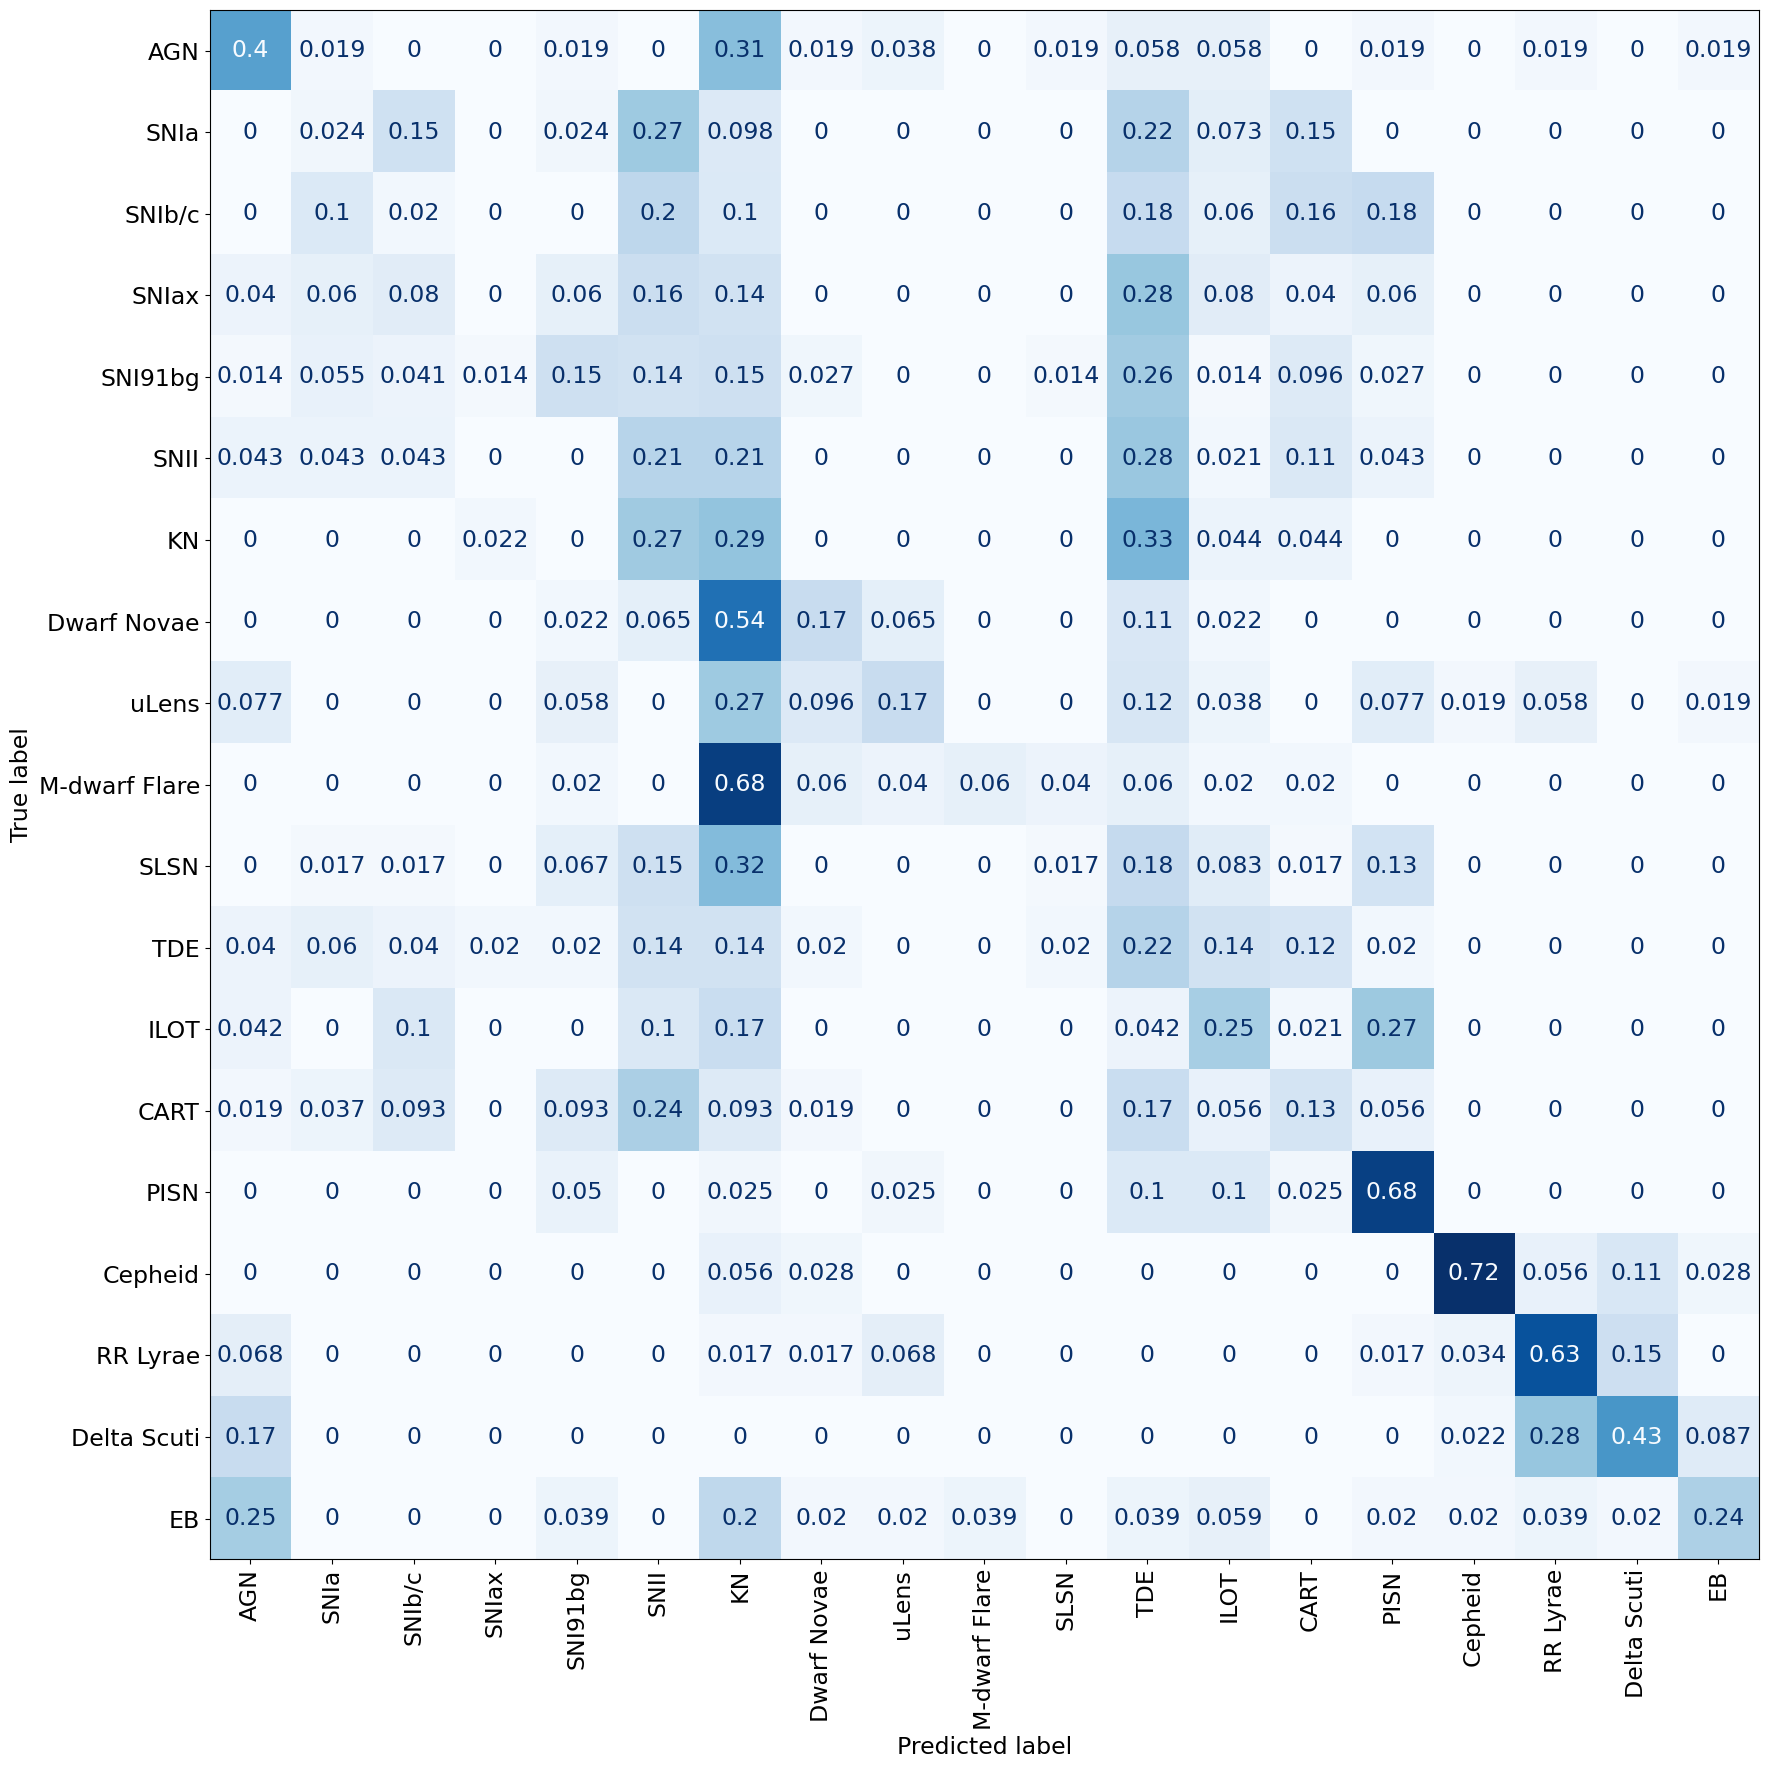

Running inference for 20% of the light curve...
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step
For 20% of the light curve, these are the statistics
               precision    recall  f1-score   support

          AGN       0.47      0.65      0.54        52
         SNIa       0.05      0.02      0.03        41
       SNIb/c       0.23      0.22      0.23        50
        SNIax       0.38      0.06      0.10        50
      SNI91bg       0.36      0.23      0.28        73
         SNII       0.12      0.09      0.10        47
           KN       0.13      0.67      0.22        45
  Dwarf Novae       0.40      0.48      0.44        46
        uLens       0.58      0.27      0.37        52
M-dwarf Flare       0.28      0.14      0.19        50
         SLSN       0.30      0.15      0.20        60
          TDE       0.19      0.24      0.21        50
         ILOT       0.33      0.33      0.33        48
         CART       0.20      0.06      0.09        54
         PISN       0.38      0.

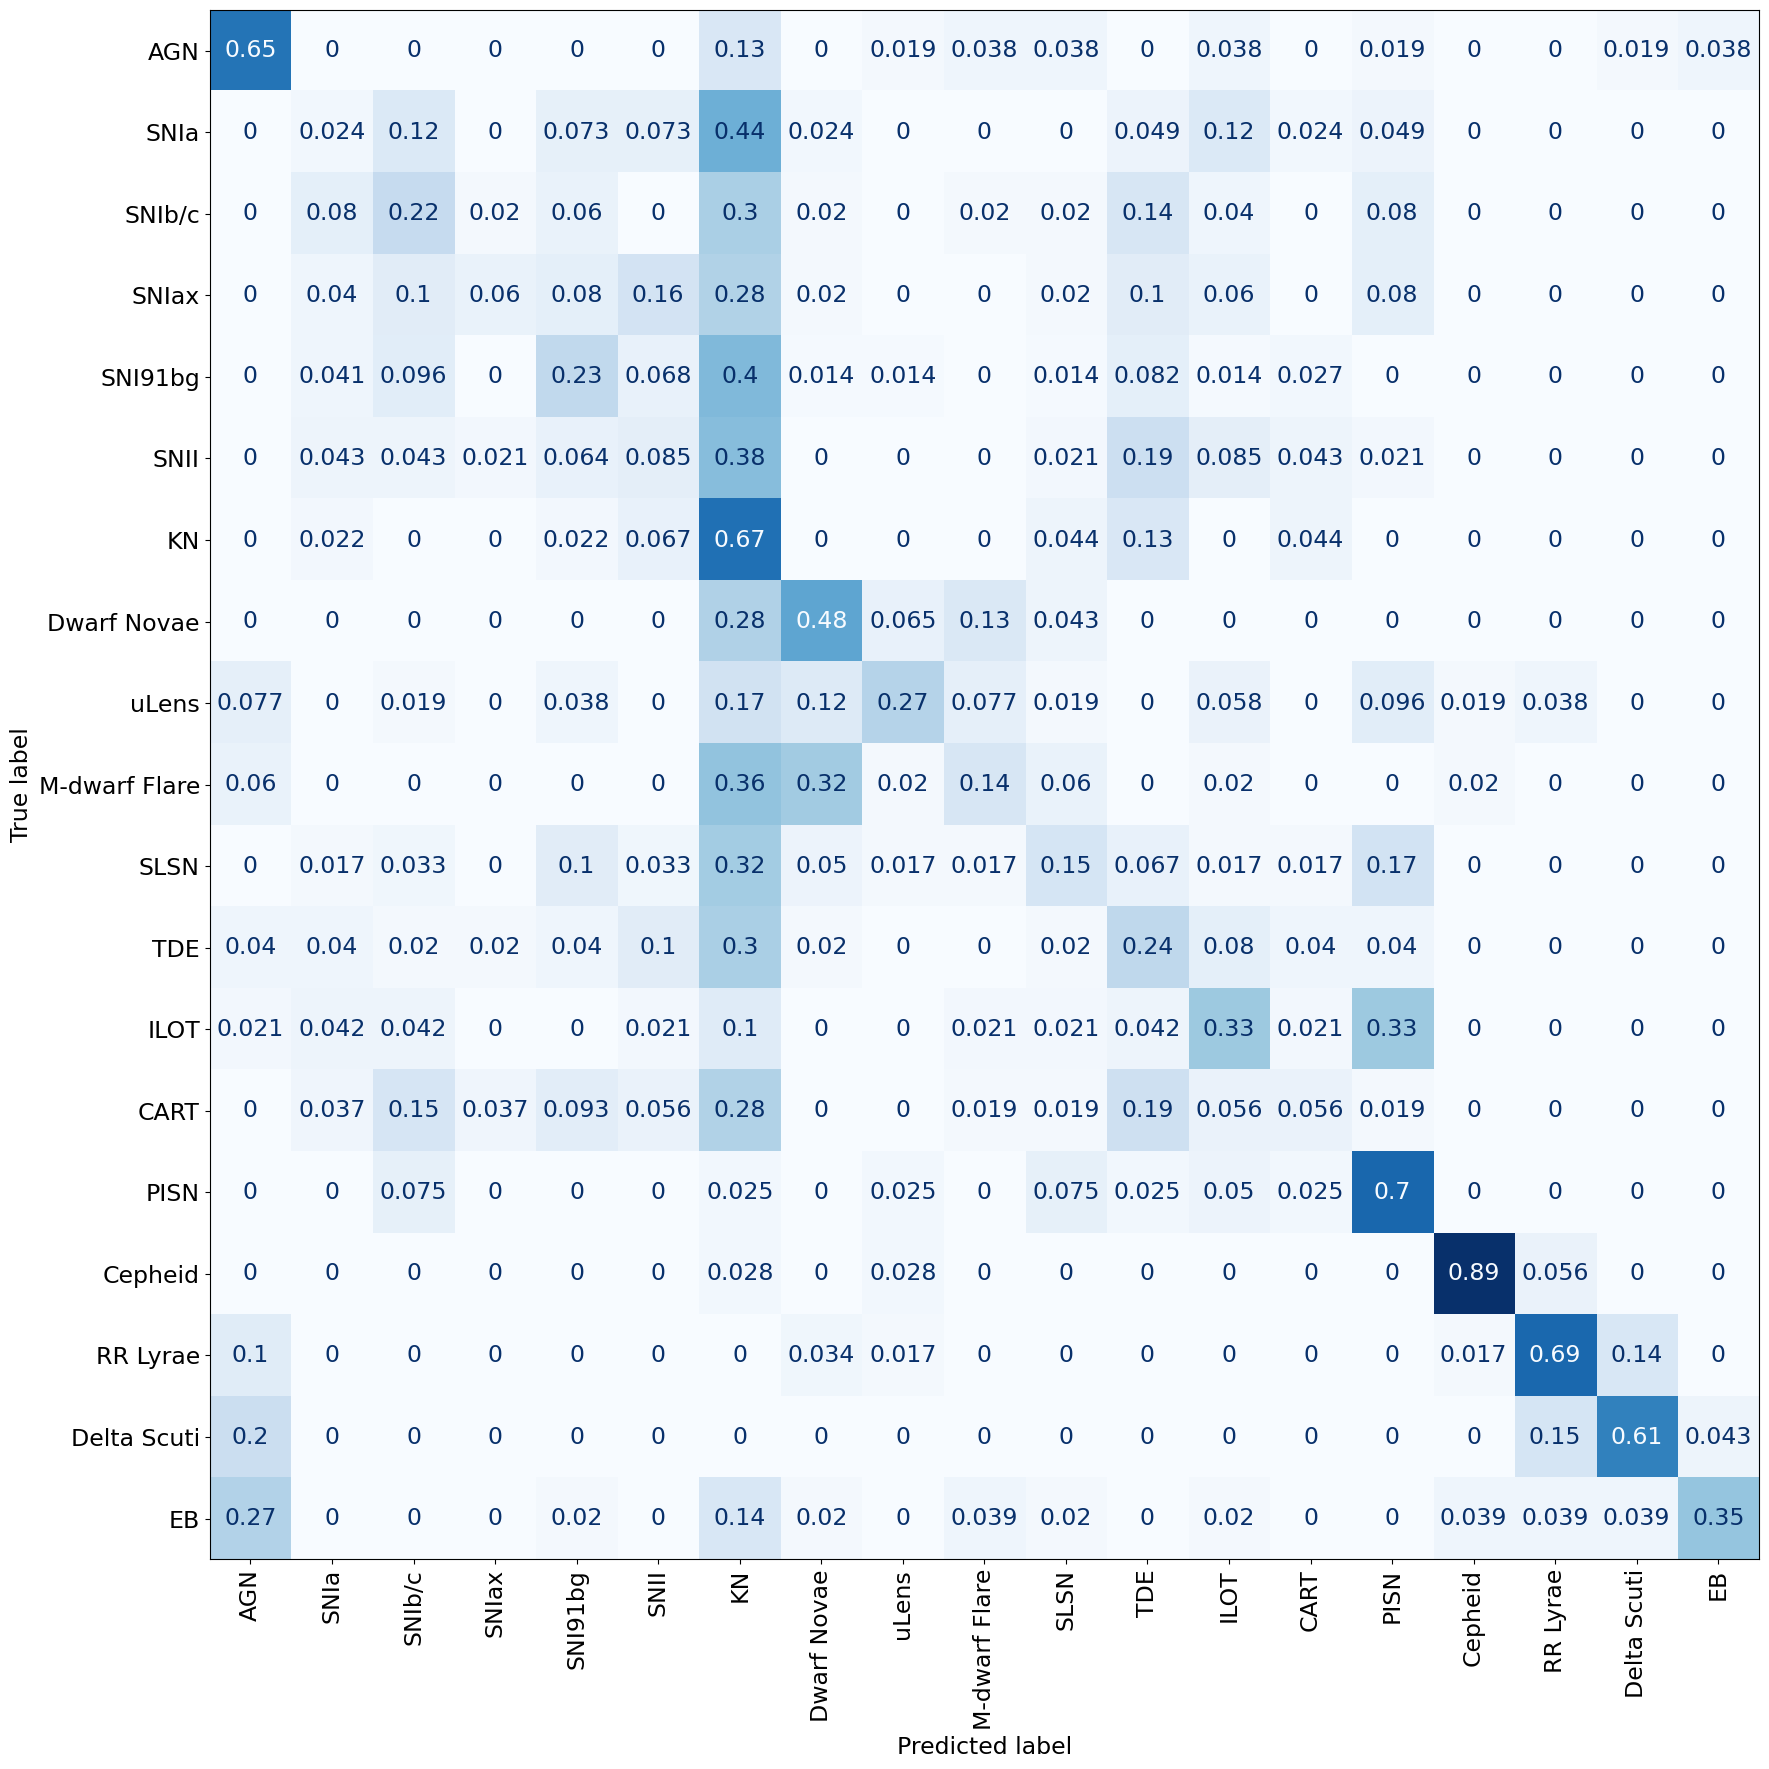

Running inference for 30% of the light curve...
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step
For 30% of the light curve, these are the statistics
               precision    recall  f1-score   support

          AGN       0.45      0.77      0.57        52
         SNIa       0.09      0.07      0.08        41
       SNIb/c       0.20      0.20      0.20        50
        SNIax       0.23      0.06      0.10        50
      SNI91bg       0.34      0.27      0.30        73
         SNII       0.20      0.11      0.14        47
           KN       0.20      0.80      0.32        45
  Dwarf Novae       0.42      0.54      0.47        46
        uLens       0.55      0.35      0.42        52
M-dwarf Flare       0.36      0.32      0.34        50
         SLSN       0.35      0.22      0.27        60
          TDE       0.36      0.32      0.34        50
         ILOT       0.37      0.29      0.33        48
         CART       0.18      0.04      0.06        54
         PISN       0.40      0.

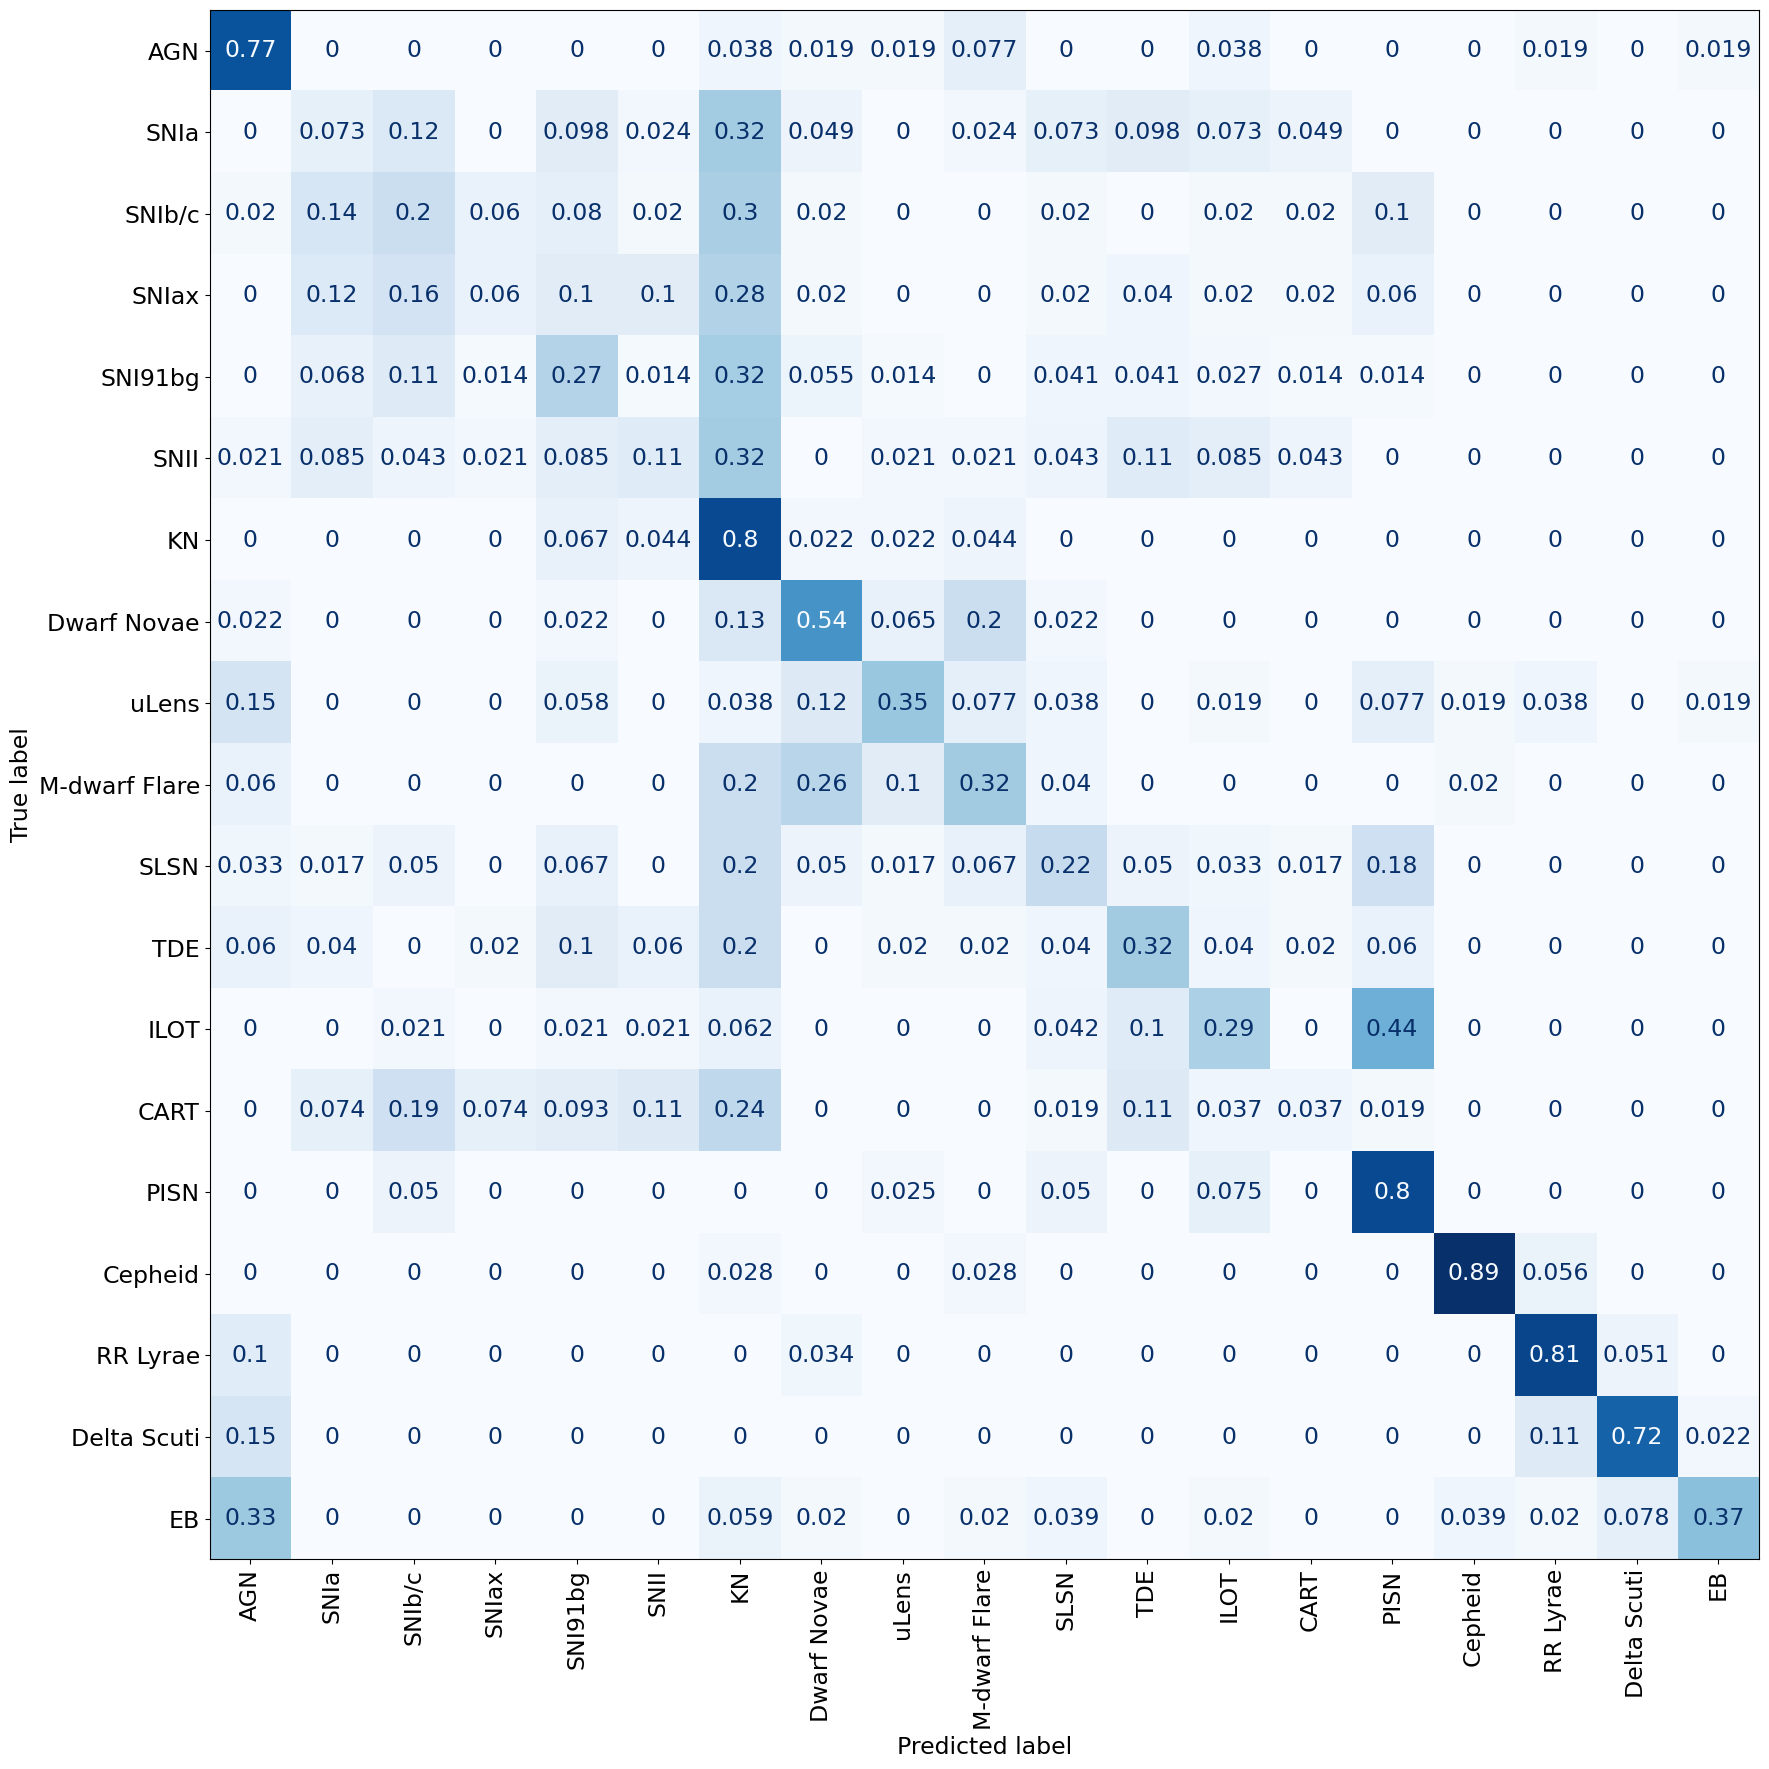

Running inference for 40% of the light curve...
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step
For 40% of the light curve, these are the statistics
               precision    recall  f1-score   support

          AGN       0.45      0.79      0.57        52
         SNIa       0.05      0.05      0.05        41
       SNIb/c       0.18      0.20      0.19        50
        SNIax       0.27      0.08      0.12        50
      SNI91bg       0.34      0.41      0.37        73
         SNII       0.19      0.13      0.15        47
           KN       0.21      0.60      0.31        45
  Dwarf Novae       0.46      0.50      0.48        46
        uLens       0.60      0.52      0.56        52
M-dwarf Flare       0.40      0.38      0.39        50
         SLSN       0.32      0.27      0.29        60
          TDE       0.50      0.32      0.39        50
         ILOT       0.50      0.44      0.47        48
         CART       0.20      0.06      0.09        54
         PISN       0.48      0.

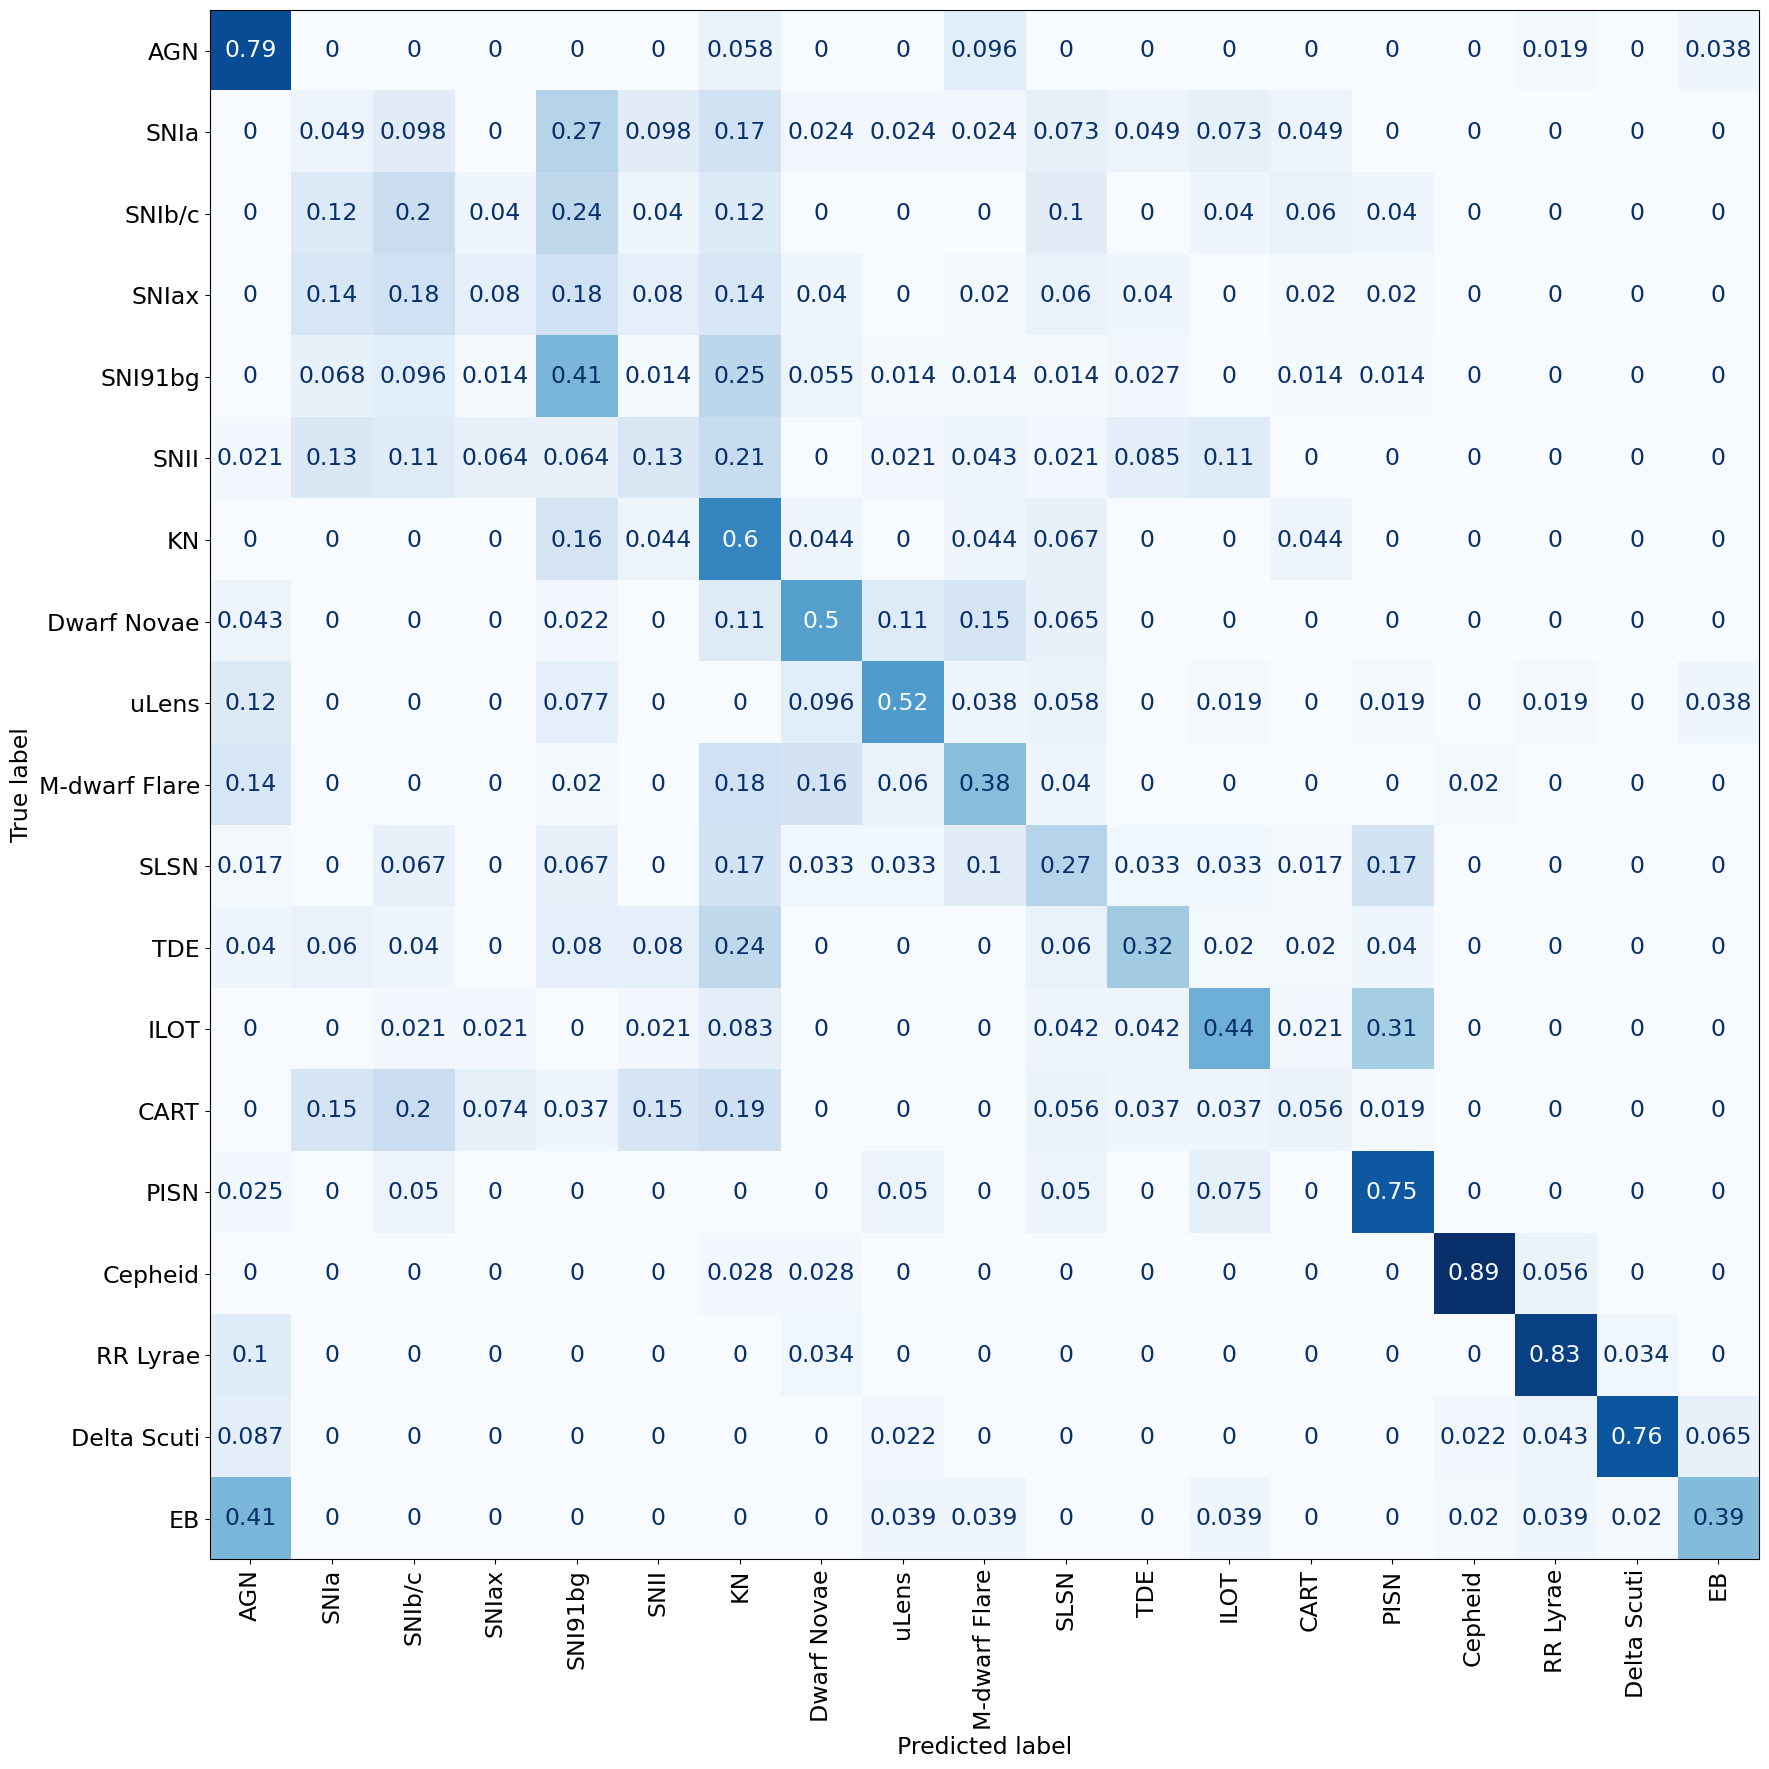

Running inference for 50% of the light curve...
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step
For 50% of the light curve, these are the statistics
               precision    recall  f1-score   support

          AGN       0.44      0.81      0.57        52
         SNIa       0.14      0.17      0.16        41
       SNIb/c       0.23      0.22      0.23        50
        SNIax       0.14      0.06      0.08        50
      SNI91bg       0.42      0.52      0.46        73
         SNII       0.12      0.06      0.08        47
           KN       0.35      0.78      0.49        45
  Dwarf Novae       0.48      0.46      0.47        46
        uLens       0.57      0.46      0.51        52
M-dwarf Flare       0.44      0.58      0.50        50
         SLSN       0.37      0.37      0.37        60
          TDE       0.41      0.38      0.40        50
         ILOT       0.52      0.35      0.42        48
         CART       0.10      0.02      0.03        54
         PISN       0.49      0.

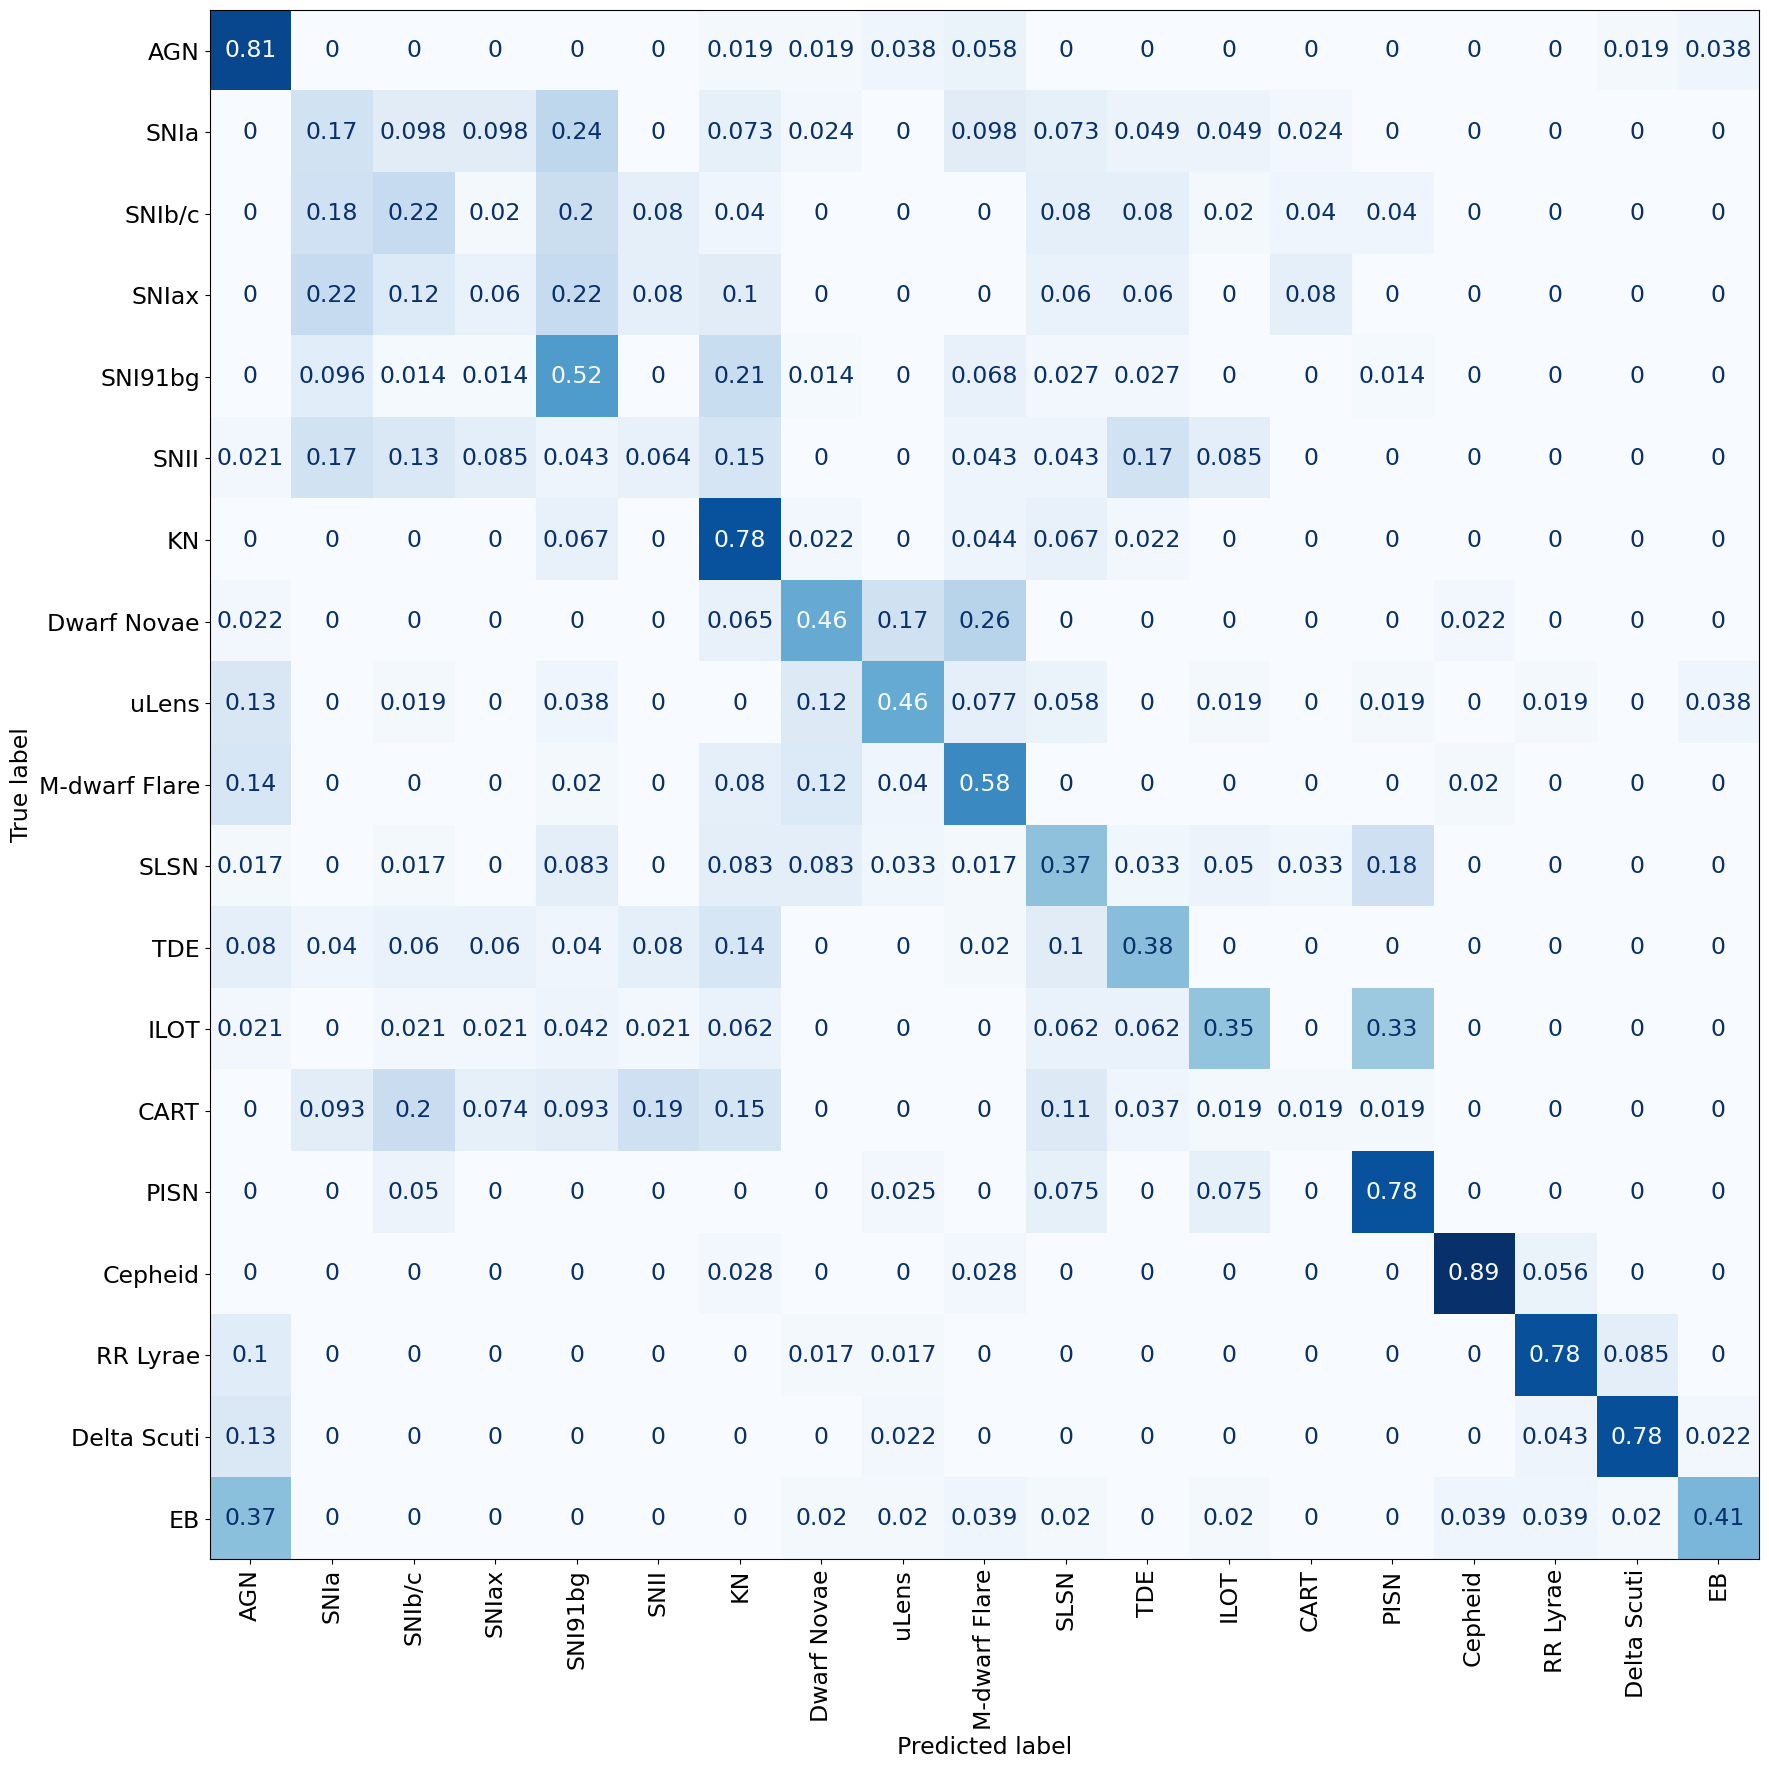

Running inference for 60% of the light curve...
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step
For 60% of the light curve, these are the statistics
               precision    recall  f1-score   support

          AGN       0.49      0.81      0.61        52
         SNIa       0.16      0.24      0.20        41
       SNIb/c       0.26      0.26      0.26        50
        SNIax       0.20      0.10      0.13        50
      SNI91bg       0.40      0.55      0.47        73
         SNII       0.17      0.06      0.09        47
           KN       0.45      0.80      0.58        45
  Dwarf Novae       0.56      0.54      0.55        46
        uLens       0.59      0.46      0.52        52
M-dwarf Flare       0.46      0.68      0.55        50
         SLSN       0.43      0.38      0.41        60
          TDE       0.54      0.40      0.46        50
         ILOT       0.58      0.46      0.51        48
         CART       0.25      0.06      0.09        54
         PISN       0.48      0.

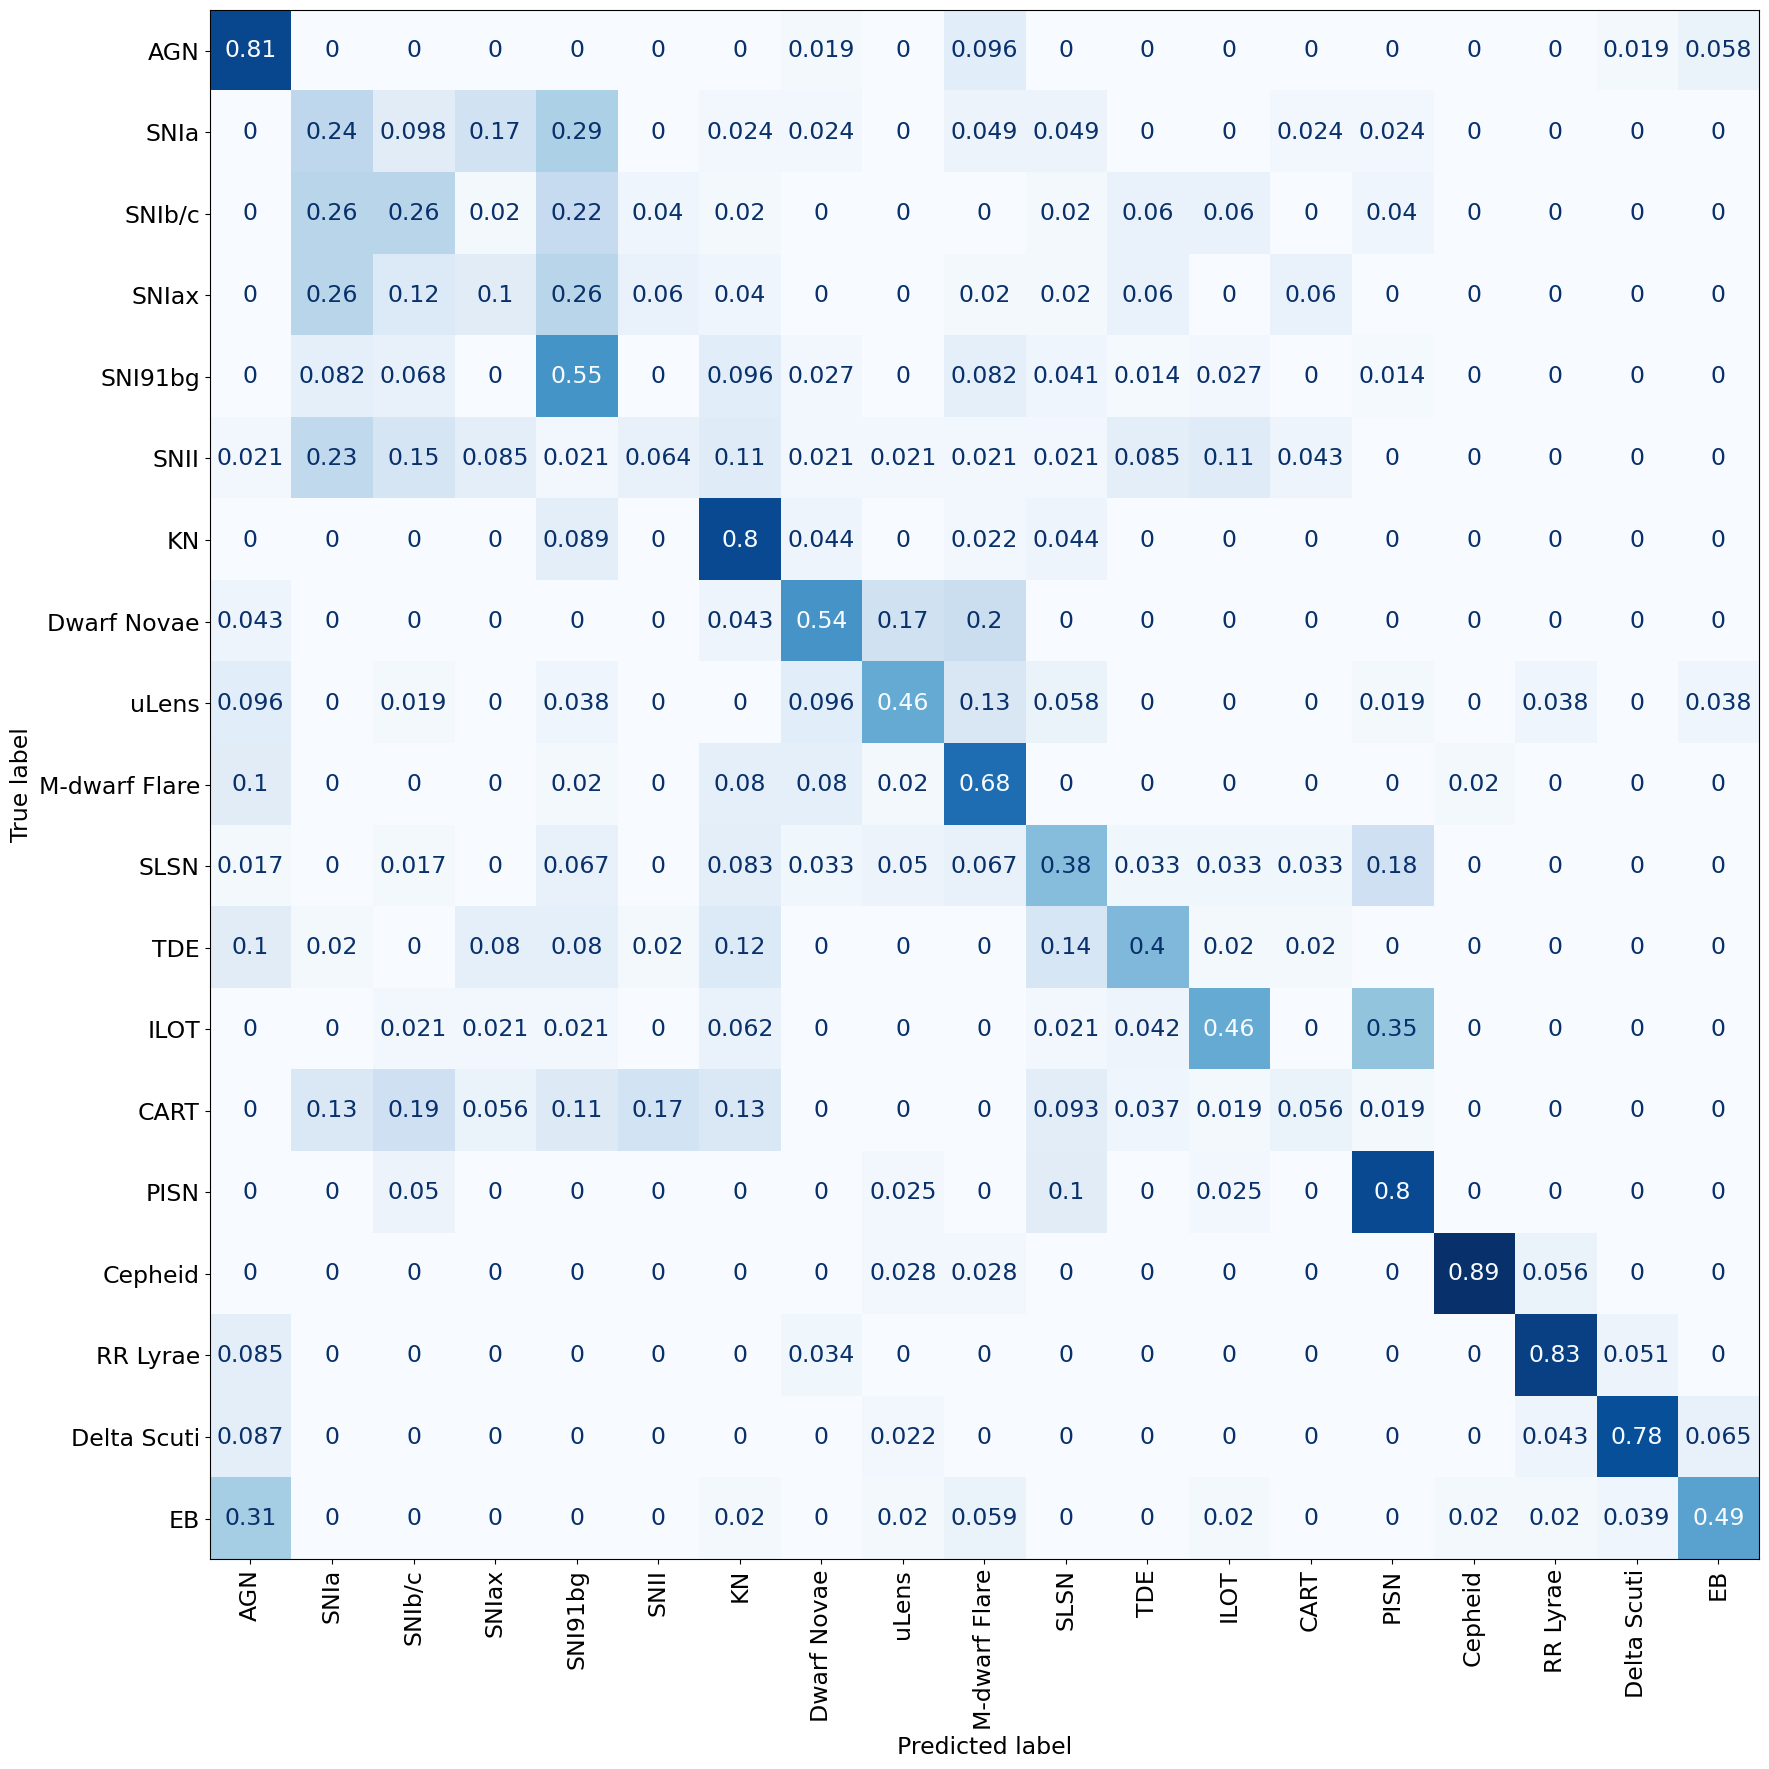

Running inference for 70% of the light curve...
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step
For 70% of the light curve, these are the statistics
               precision    recall  f1-score   support

          AGN       0.48      0.85      0.62        52
         SNIa       0.20      0.29      0.24        41
       SNIb/c       0.28      0.30      0.29        50
        SNIax       0.24      0.12      0.16        50
      SNI91bg       0.42      0.58      0.49        73
         SNII       0.19      0.06      0.10        47
           KN       0.55      0.84      0.67        45
  Dwarf Novae       0.73      0.65      0.69        46
        uLens       0.68      0.58      0.62        52
M-dwarf Flare       0.46      0.64      0.54        50
         SLSN       0.52      0.48      0.50        60
          TDE       0.48      0.48      0.48        50
         ILOT       0.68      0.48      0.56        48
         CART       0.25      0.07      0.11        54
         PISN       0.51      0.

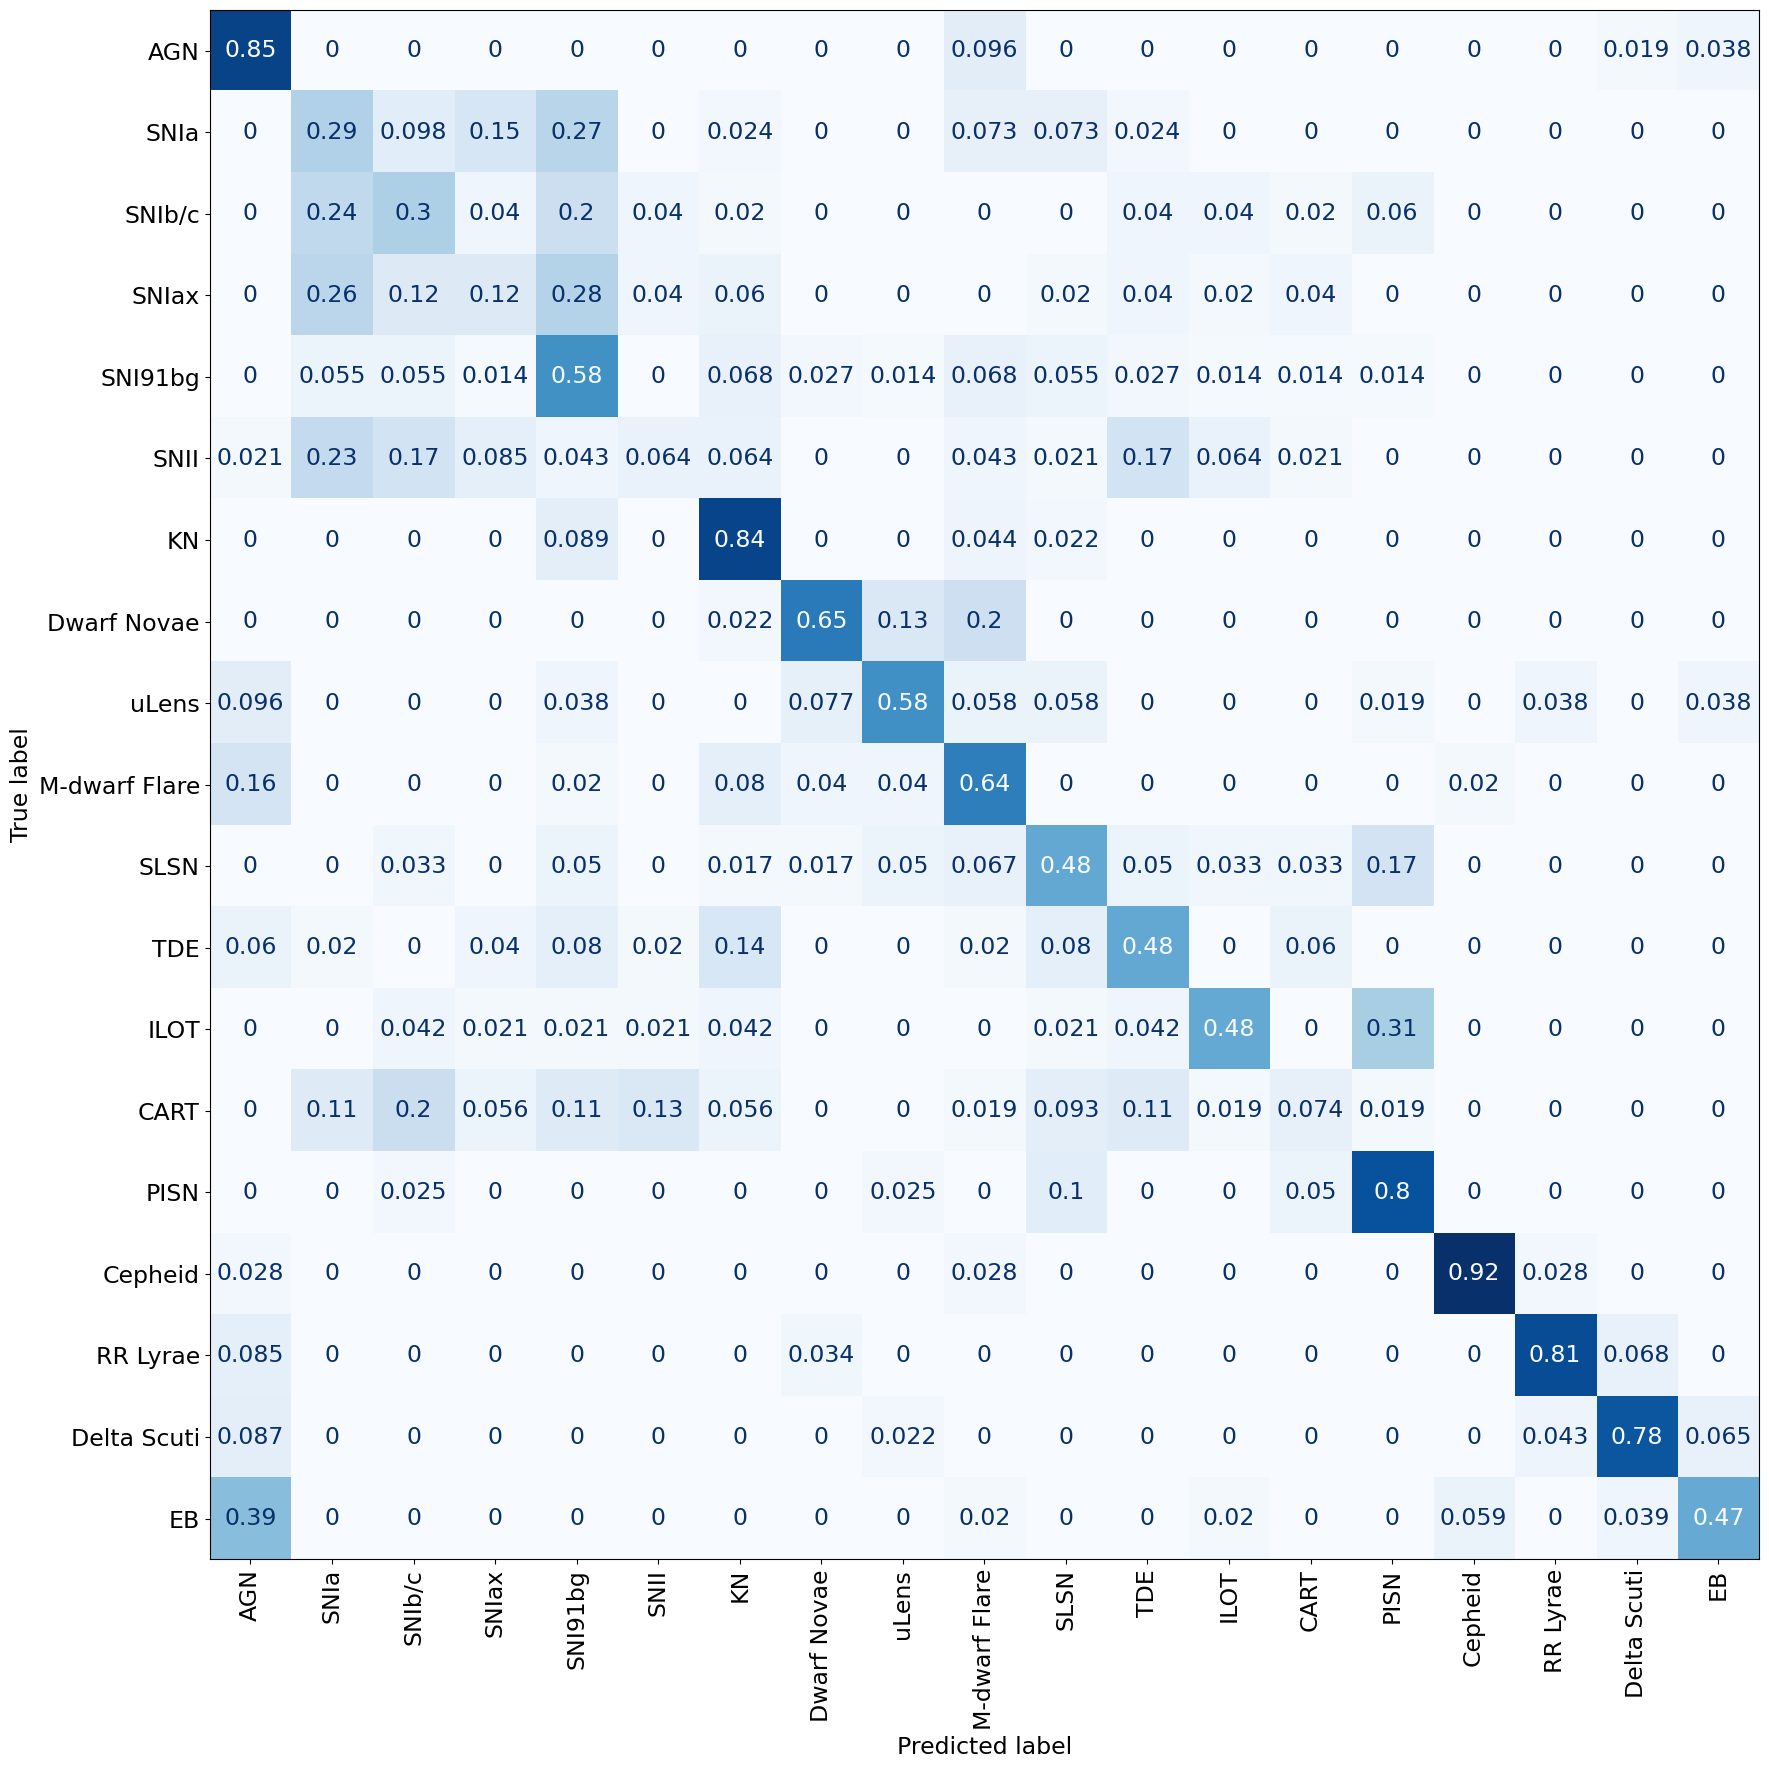

Running inference for 80% of the light curve...
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step
For 80% of the light curve, these are the statistics
               precision    recall  f1-score   support

          AGN       0.47      0.85      0.60        52
         SNIa       0.18      0.29      0.23        41
       SNIb/c       0.32      0.32      0.32        50
        SNIax       0.27      0.14      0.18        50
      SNI91bg       0.43      0.64      0.52        73
         SNII       0.38      0.13      0.19        47
           KN       0.65      0.82      0.73        45
  Dwarf Novae       0.80      0.70      0.74        46
        uLens       0.65      0.58      0.61        52
M-dwarf Flare       0.51      0.72      0.60        50
         SLSN       0.52      0.50      0.51        60
          TDE       0.57      0.52      0.54        50
         ILOT       0.63      0.46      0.53        48
         CART       0.17      0.06      0.08        54
         PISN       0.50      0.

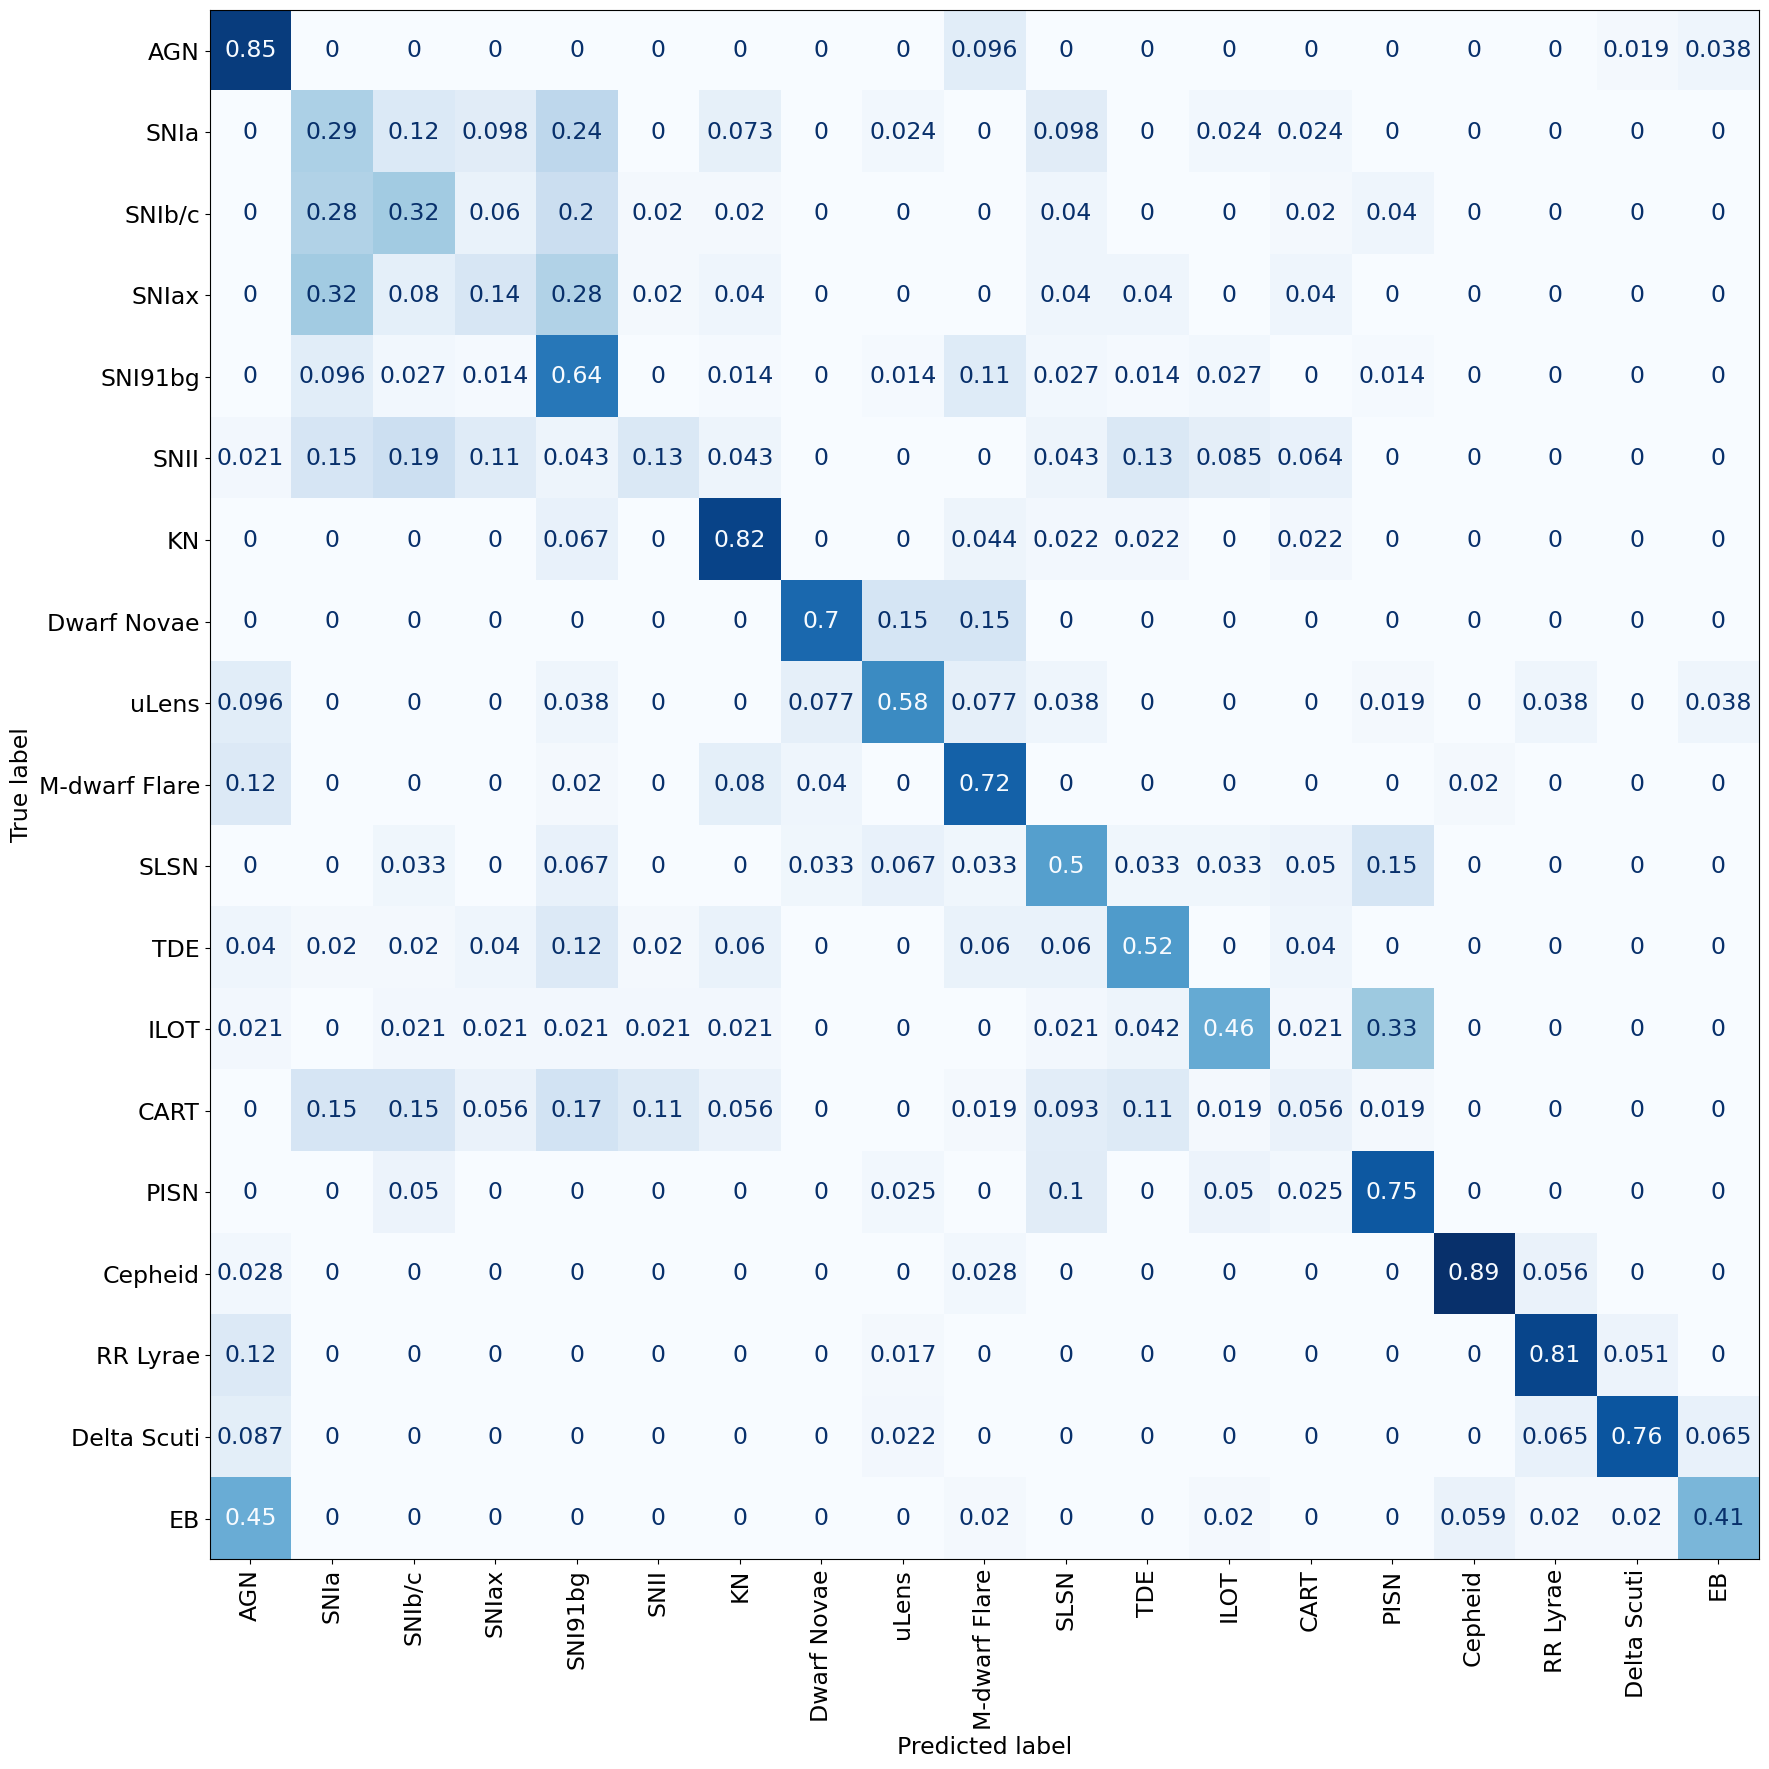

Running inference for 90% of the light curve...
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step
For 90% of the light curve, these are the statistics
               precision    recall  f1-score   support

          AGN       0.49      0.88      0.63        52
         SNIa       0.19      0.32      0.24        41
       SNIb/c       0.30      0.30      0.30        50
        SNIax       0.27      0.16      0.20        50
      SNI91bg       0.45      0.67      0.54        73
         SNII       0.47      0.19      0.27        47
           KN       0.74      0.93      0.82        45
  Dwarf Novae       0.86      0.80      0.83        46
        uLens       0.72      0.63      0.67        52
M-dwarf Flare       0.69      0.76      0.72        50
         SLSN       0.64      0.62      0.63        60
          TDE       0.52      0.50      0.51        50
         ILOT       0.68      0.48      0.56        48
         CART       0.30      0.11      0.16        54
         PISN       0.53      0.

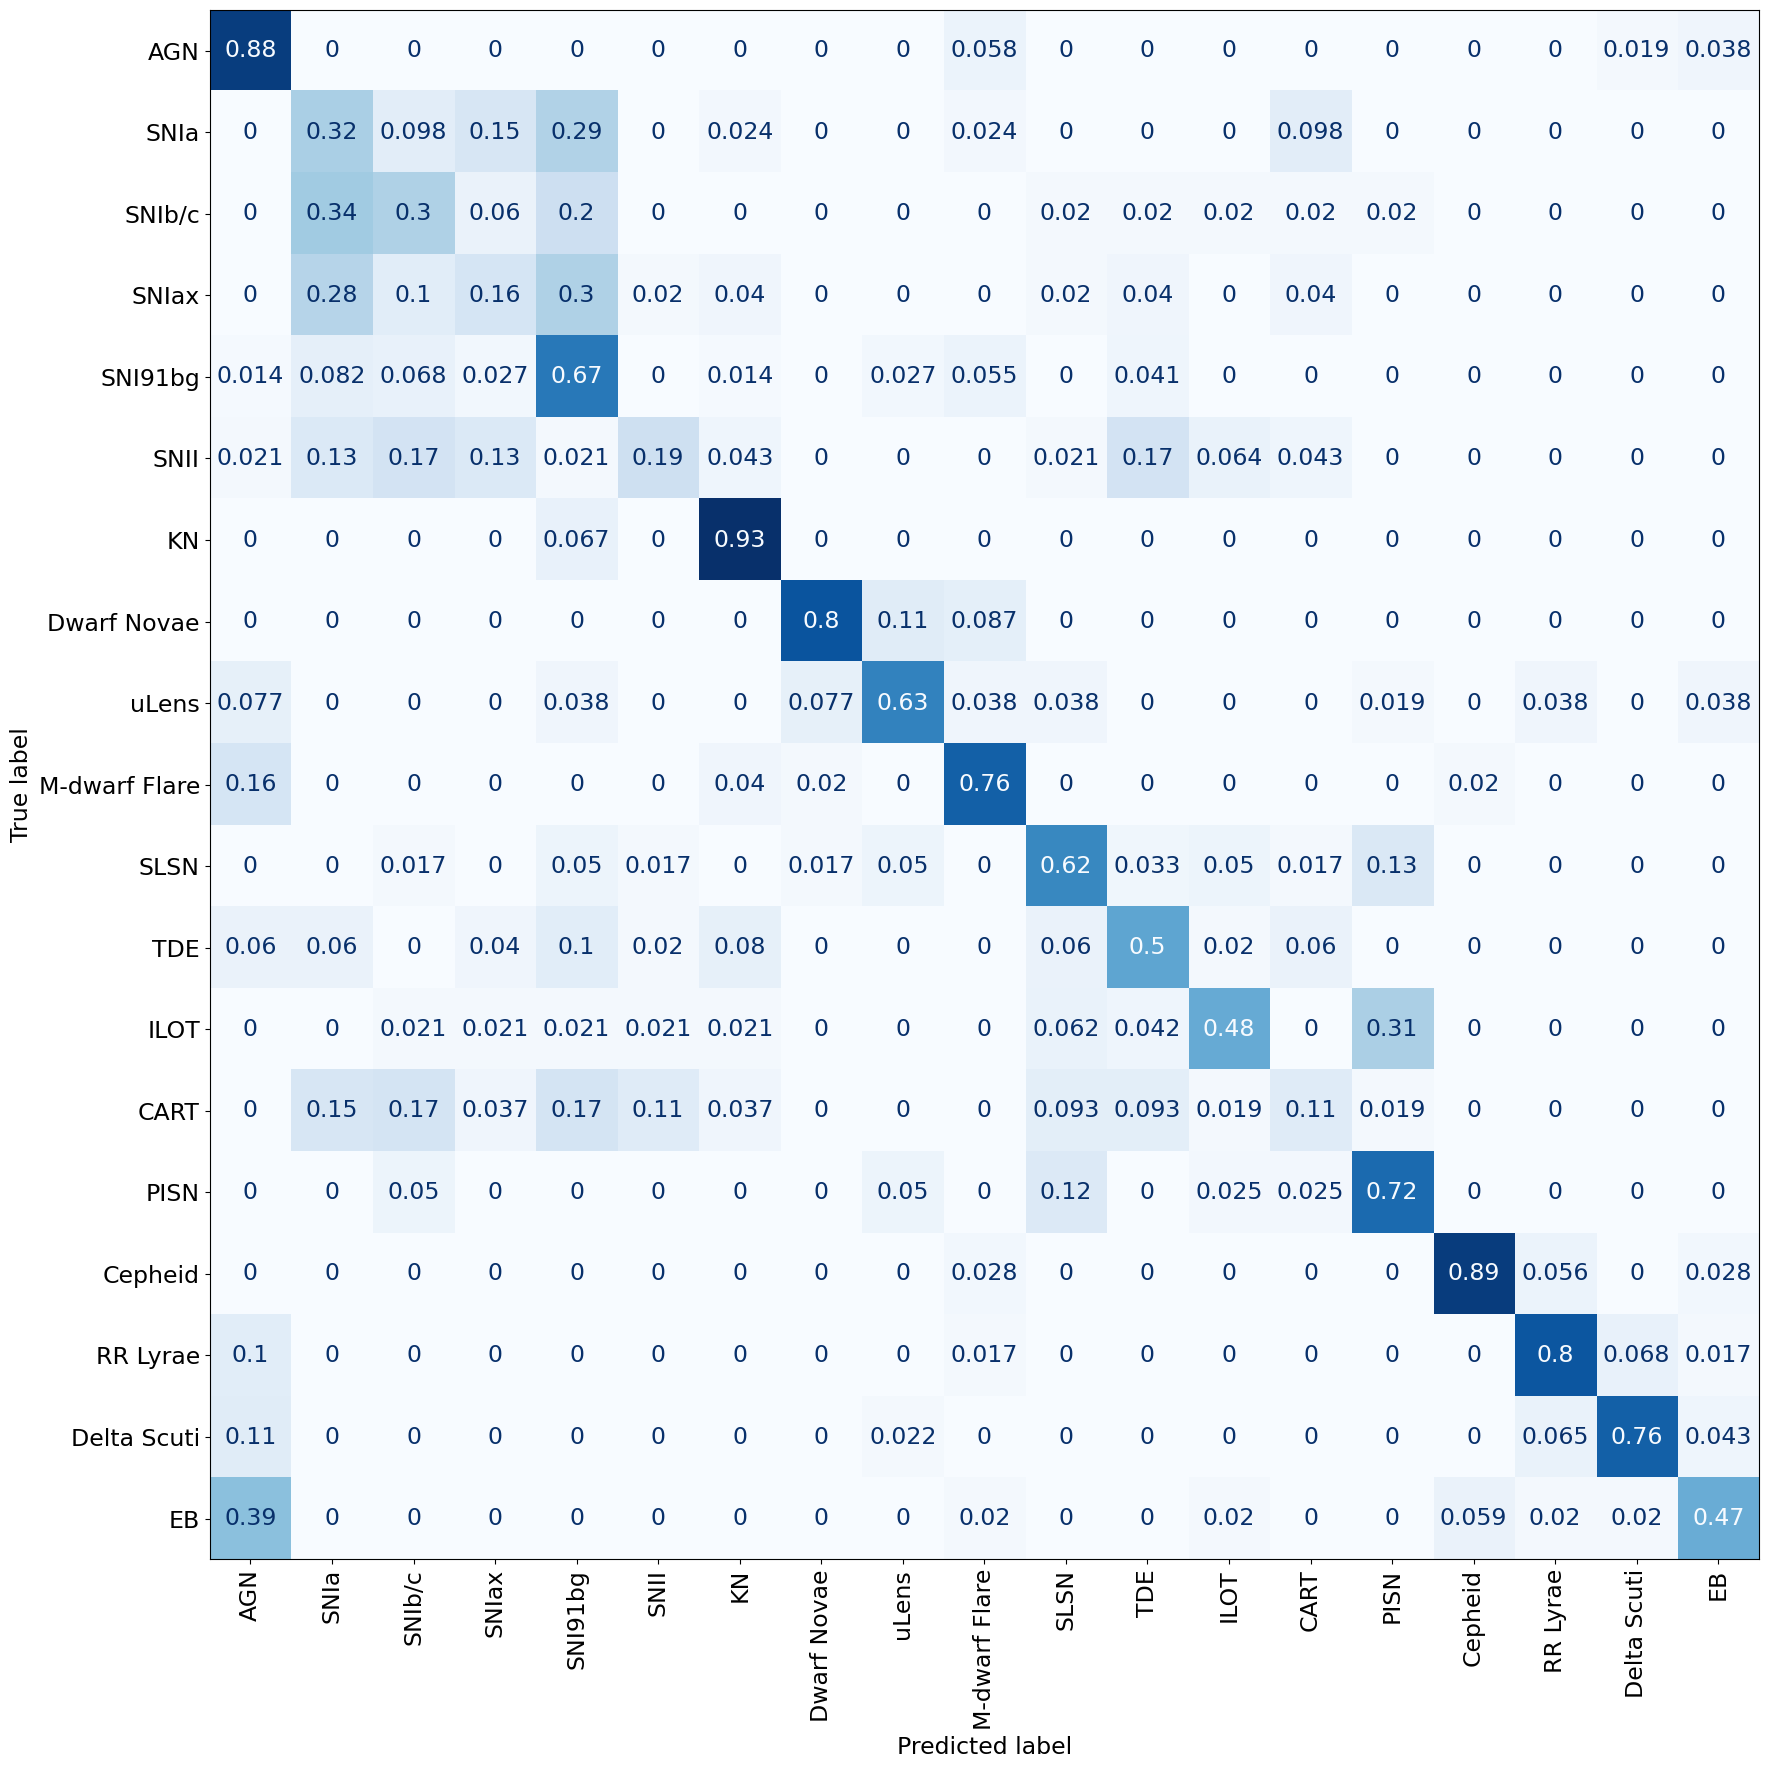

Running inference for 100% of the light curve...
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step
For 100% of the light curve, these are the statistics
               precision    recall  f1-score   support

          AGN       0.48      0.87      0.62        52
         SNIa       0.19      0.32      0.24        41
       SNIb/c       0.28      0.28      0.28        50
        SNIax       0.31      0.16      0.21        50
      SNI91bg       0.46      0.66      0.54        73
         SNII       0.56      0.21      0.31        47
           KN       0.74      0.89      0.81        45
  Dwarf Novae       0.87      0.85      0.86        46
        uLens       0.78      0.69      0.73        52
M-dwarf Flare       0.76      0.82      0.79        50
         SLSN       0.67      0.72      0.69        60
          TDE       0.53      0.60      0.56        50
         ILOT       0.71      0.52      0.60        48
         CART       0.28      0.09      0.14        54
         PISN       0.56      

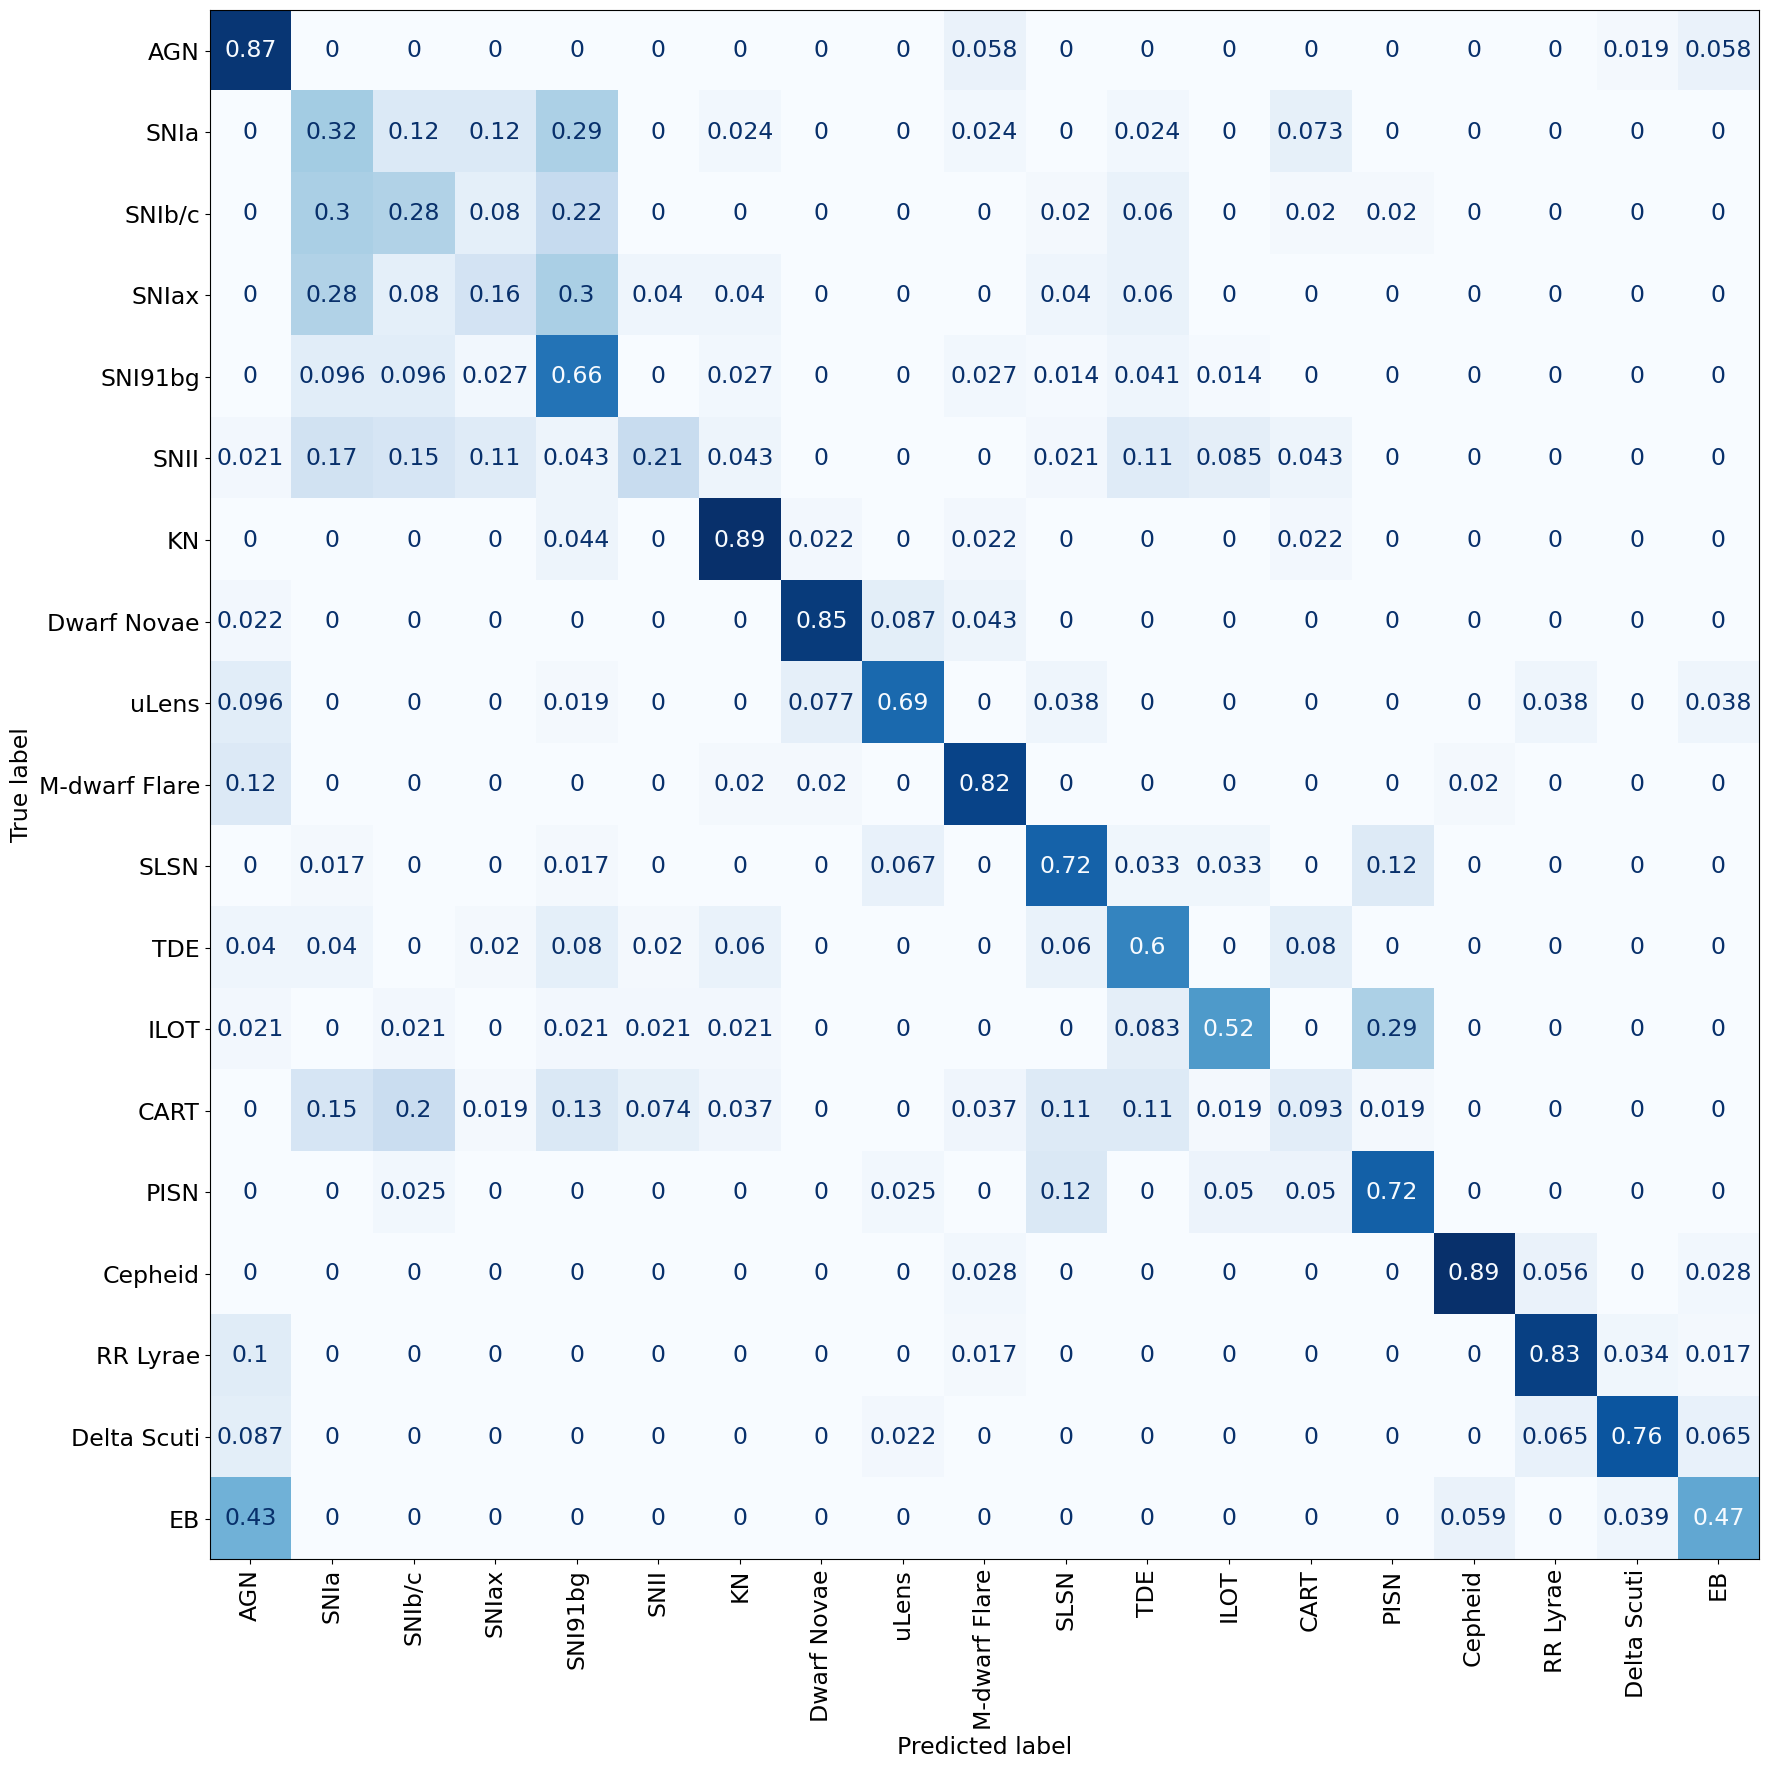

In [72]:

for f in fractions:

    print(f'Running inference for {int(f*100)}% of the light curve...')

    # Get all the indices for where 'f' fraction of the LC was used
    idx = np.where(lc_fraction_val == f)[0]

    # Run inference on these
    x1 = X_ts_val[idx, :, :]
    x2 = X_static_val[idx]
    y_pred = model1.predict([x1, x2])

    # Get the predictions at the leaf
    for i in range(y_pred.shape[0]):
    
        pseudo_probs, weighted_tree = get_prediction_probs(y_pred[[i], :])
        leaf_prob , _ = get_highest_prob_path(weighted_tree)
        y_pred[i, -19:] =  leaf_prob

    y_pred = np.argmax(y_pred[:, -19:], axis=1)
    y_true = np.argmax(Y_val[idx, -19:], axis=1)

    # Print the stats
    print(f'For {int(f*100)}% of the light curve, these are the statistics')
    report = classification_report(y_true, y_pred, target_names=list(loss_object.level_order_nodes)[-19:])
    print(report)

    # Make plots
    font = {'size'   : 17}
    plt.rc('font', **font)
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(loss_object.level_order_nodes)[-19:])
    disp.plot(cmap=plt.cm.Blues)
    disp.im_.colorbar.remove()
    
    fig = disp.figure_
    plt.xticks(rotation=90)
    
    
    fig.set_figwidth(18)
    fig.set_figheight(18)
    plt.tight_layout()

    plt.savefig(f"gif/{f}.png")
    plt.show()

## Making a cool animation:

/var/folders/t6/gdw9ytlx48nd402t7_62k3r00000gn/T/ipykernel_31821/41312615.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


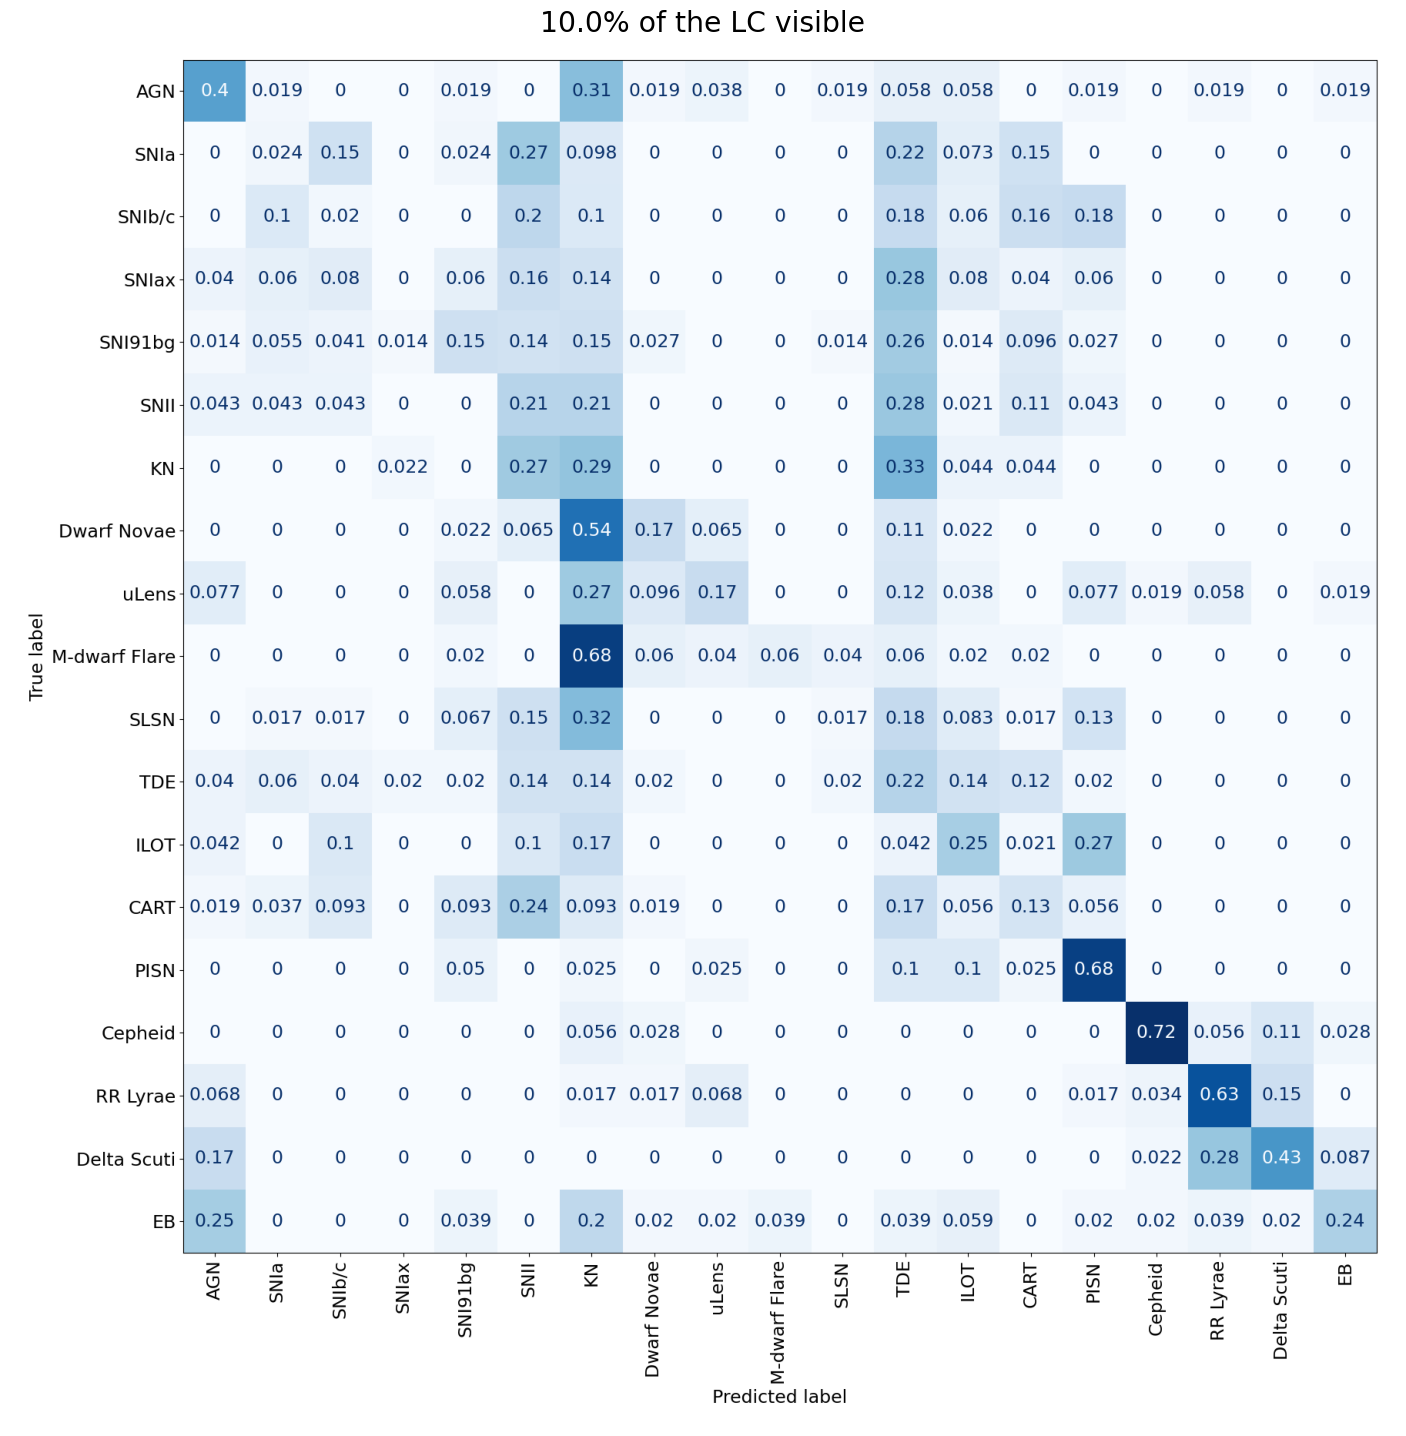

In [89]:
# Load the images
files = [f"gif/{f}.png" for f in fractions]
images = []
for filename in files:
    images.append(imageio.imread(filename))

# Create the figure and axes
fig, ax = plt.subplots(figsize=(18, 18))


# Create the animation
def animate(i):
    ax.clear()
    ax.axis('off')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(f"{fractions[i] * 100}% of the LC visible")
    ax.imshow(images[i])
    

anim = animation.FuncAnimation(fig, animate, frames=len(images), interval=500)

# Save the animation as a GIF
anim.save('gif/leaf_cf.gif')

For the love of everthing that is good in this world, please use a different notebook for testing and genearting statistics. Keep this notebook simple enought to be converted into a script. 